In [1]:
%config Completer.use_jedi = False

In [1]:
%load_ext autoreload
%autoreload 2
import sklearn
import matplotlib
import matplotlib.font_manager as font_manager
import ncempy.io as nio
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import math
from sklearn.model_selection import train_test_split
# from Materials_Project_Functions import *
from Analysis_objects_and_functions import *
from sklearn.metrics import r2_score
import glob
from mp_api.client import MPRester
from sklearn import tree
import pydotplus
import pickle
from platform import python_version

In [2]:
print('python version ' + python_version())
print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('sklearn version ' + sklearn.__version__)
print('matplotlib version ' + matplotlib.__version__)
print('joblib version ' + joblib.__version__)

python version 3.10.12
pandas version 1.5.3
numpy version 1.24.3
sklearn version 1.0.2
matplotlib version 3.7.1
joblib version 1.1.0


In [3]:
from mp_api.client import MPRester

<font size="6"> Load Data and Define XAS/EELS Analysis Object

In [4]:
test_rf_obj = eels_rf_setup('final_df_new_test.joblib') # initialize analysis object and add dataset path to it t
test_rf_obj.load_spectra_df() # load dataframe 
test_rf_obj.augment_df_with_mixtures() # run augmentation function that adds mixture spectra to the dataframe 

# load lists containing whether each spectrum is stable/has been synthesized
prop_labeling_stable = joblib.load('prop_labeling_stable.joblib') 
prop_labeling_exp = joblib.load('prop_labeling_exp.joblib')

test_rf_obj.spectra_df['is_stable'] = prop_labeling_stable 
test_rf_obj.spectra_df['is_theoretical'] = prop_labeling_exp # if this is false, the material has been synthesized. This is how 
# the materials project defines this quantity

In [5]:
# uncomment to visualize dataframe 
# test_rf_obj.spectra_df

# percent of the test set that is an integer before mixture dataset is generated 
print(sum(np.asarray(test_rf_obj.spectra_df.iloc[0:3426]['BV Used For Alignment'].value_counts())[0:3])/3426)


0.9319906596614127


<font size="6"> Train Random Foreset Model and Visualize Results - All 3 Components of Figure 2

In [5]:
# train random forest model with the cumulative spectrum, 500 trees, no max depth and all features available  
test_rf_obj.random_forest_train_bond_valance(bv_column='BV Used For Alignment',
                           spectra_to_predict = 'Cumulative_Spectra_TEAM_1_aligned_925_970',
                        energy_col = 'new Scaled Energies use', 
                                             max_features = 'auto')

len training data = 7067
Using column: Cumulative_Spectra_TEAM_1_aligned_925_970 to predict: BV Used For Alignment
model accuracy (R^2) on simulated test data 0.8889127604122083


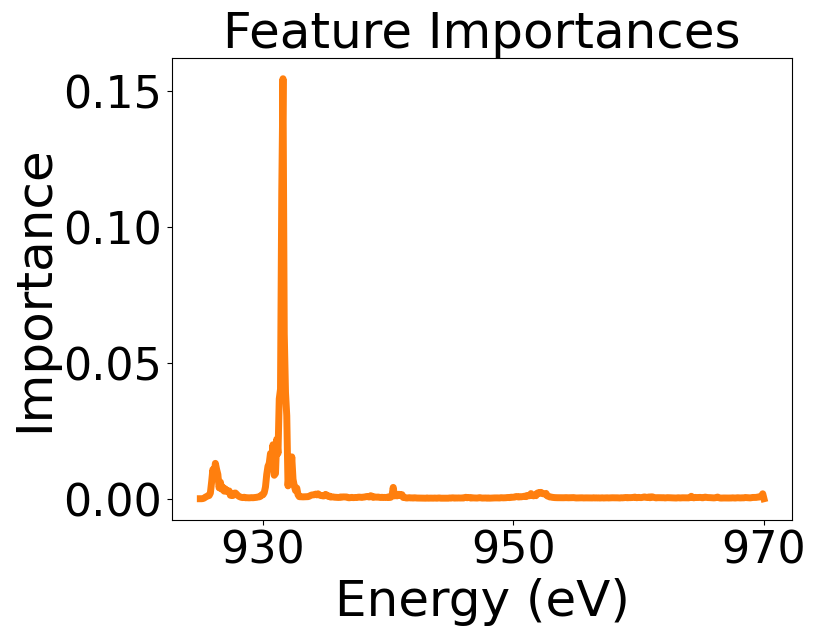

In [6]:
test_rf_obj.show_feature_importances('Cu', savefigure=True)
# visualize feature importances for the RF model 

num spectra = 2356
model accuracy (R^2) on simulated test data 0.8889127604122083


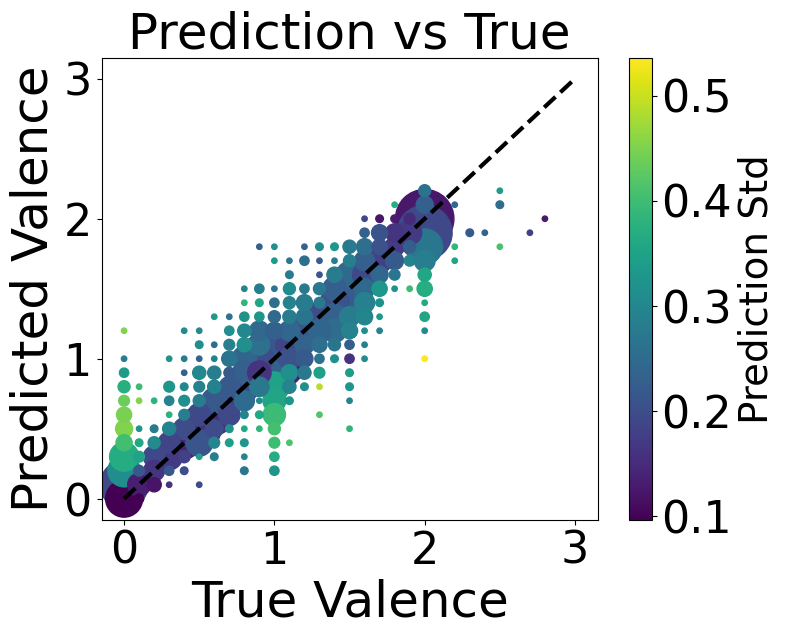

In [7]:
test_rf_obj.show_r2(savefigure=True)
# Show R2 plot for simulated data reserved from training. The top plot shows data colored by the number of points at 
# that position, while the bottom plot is colored by prediction standard deviation

RMSE 0.20825025504909622


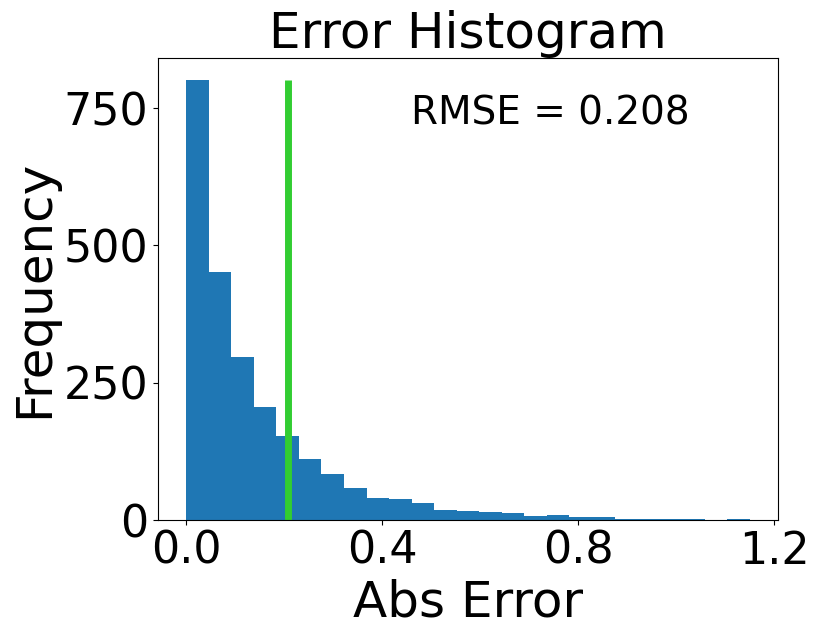

In [8]:
test_rf_obj.show_errors_histogram(nbins=25, savefigure=True)
# show error histogram for simulated data reserved from training. The solid green line is the location of the RMSE 

<font size="6"> Visualize Dataset Distribution and The creation of Mixture Samples. Figure 1 II and III, and Figure S4

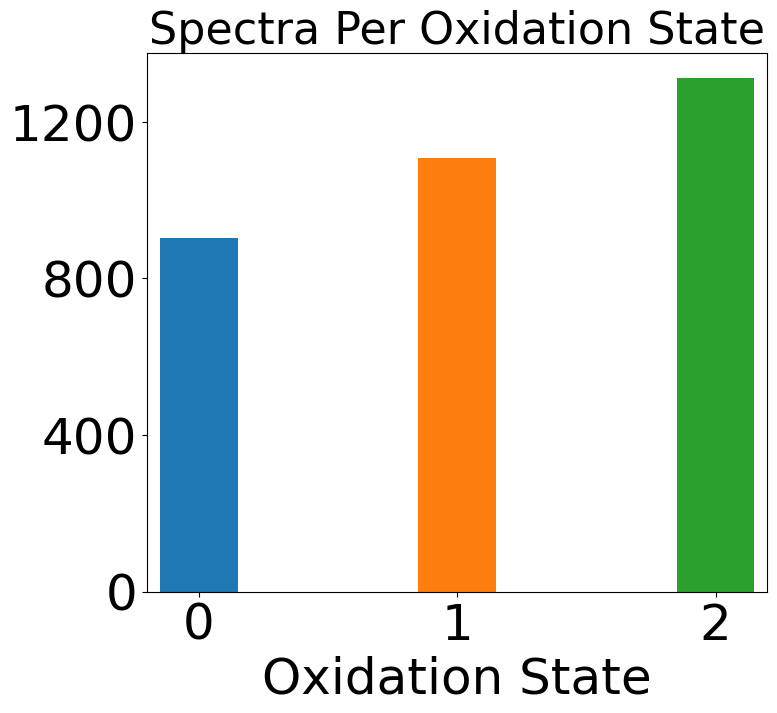

In [69]:
# show the number of integer valence spectra in the dataset before mixture generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=False, savefigure=True)

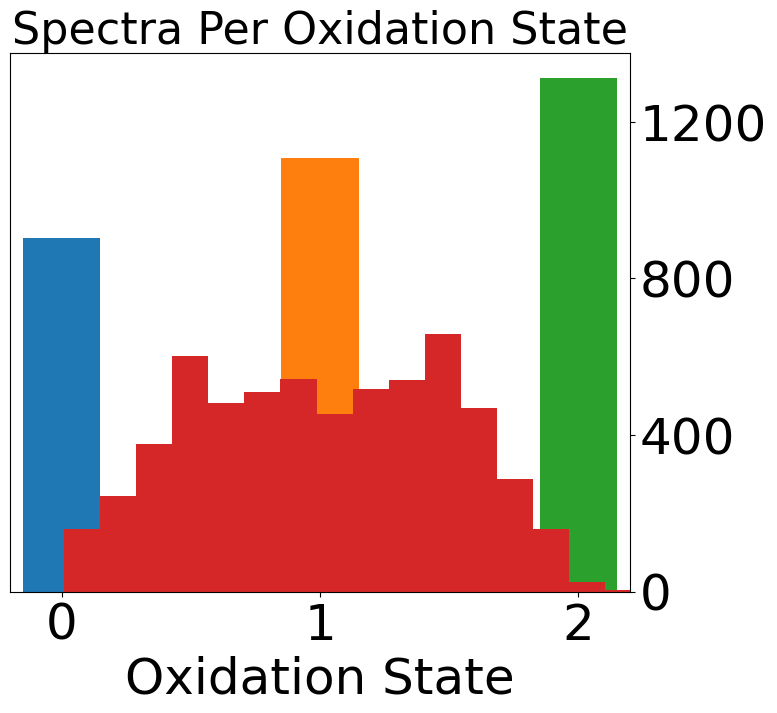

In [68]:
# show the spread of oxidation states post mixture dataset generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=True, savefigure=True, right_y_ticks = True)

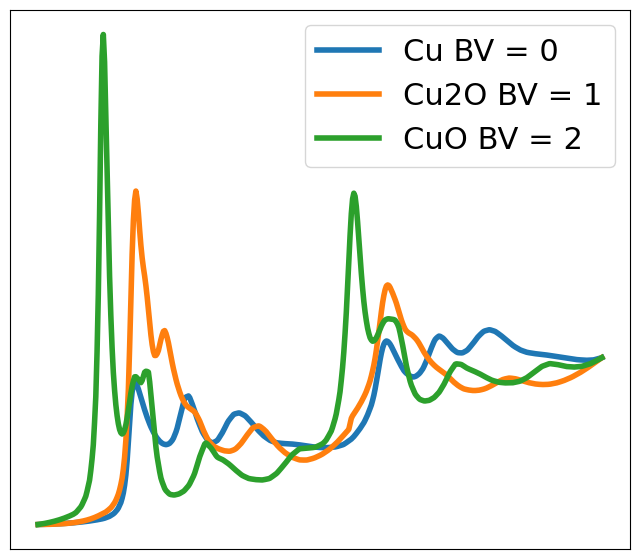

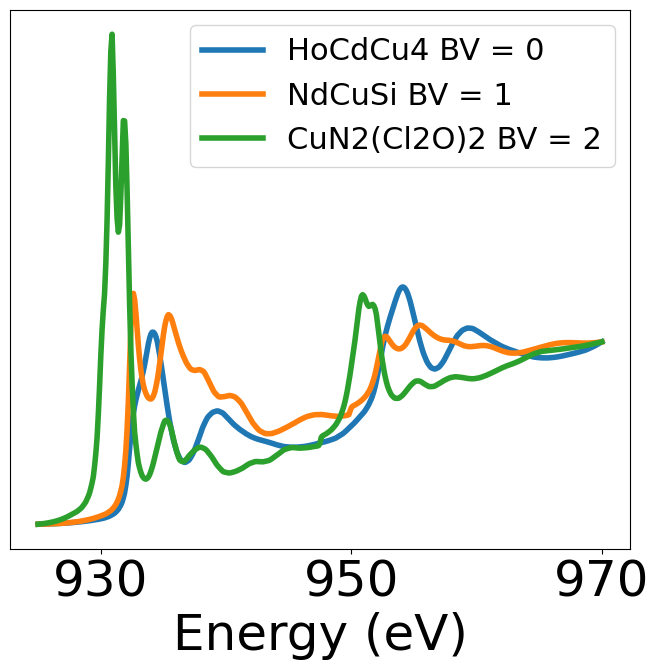

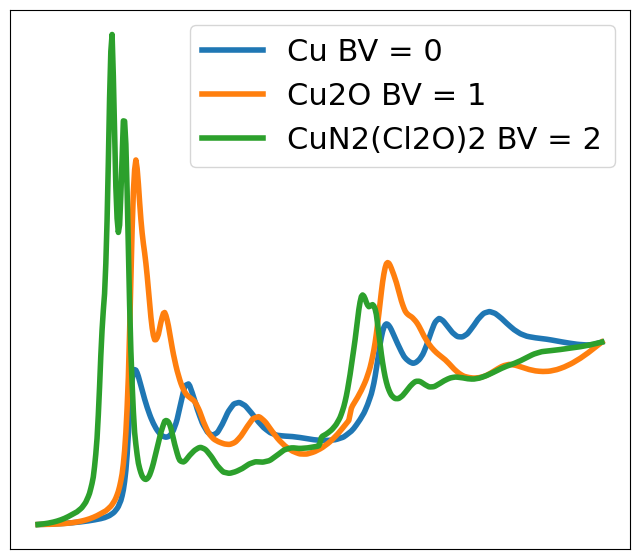

In [66]:
# visualize specific integer oxidation state spectra 
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-704645', include_title=False, include_ticks = False, 
                                         savefigure=True)
test_rf_obj.visualize_mixture_components('mp-12007', 'mp-8120', 'mp-1188453', include_title=False, savefigure=True)
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-1188453', include_title=False, include_ticks = False, savefigure=True)

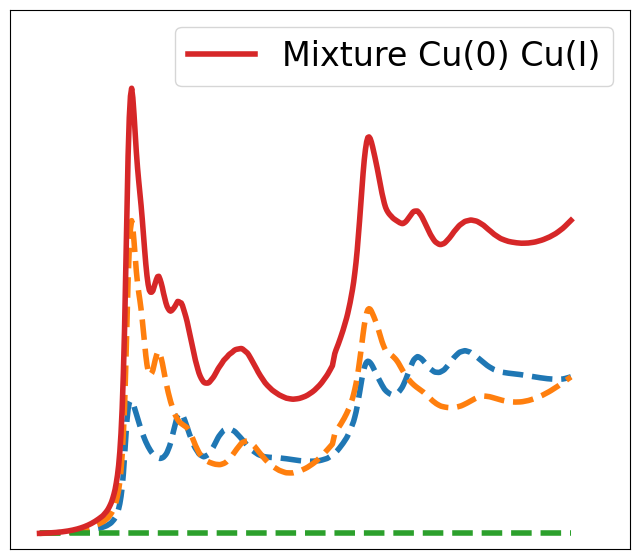

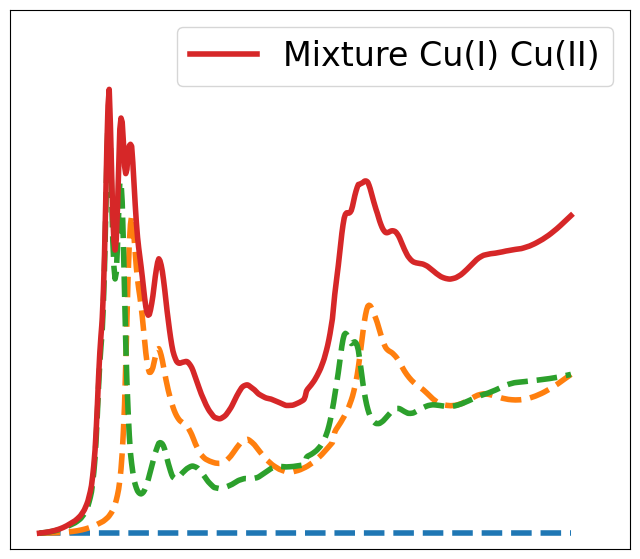

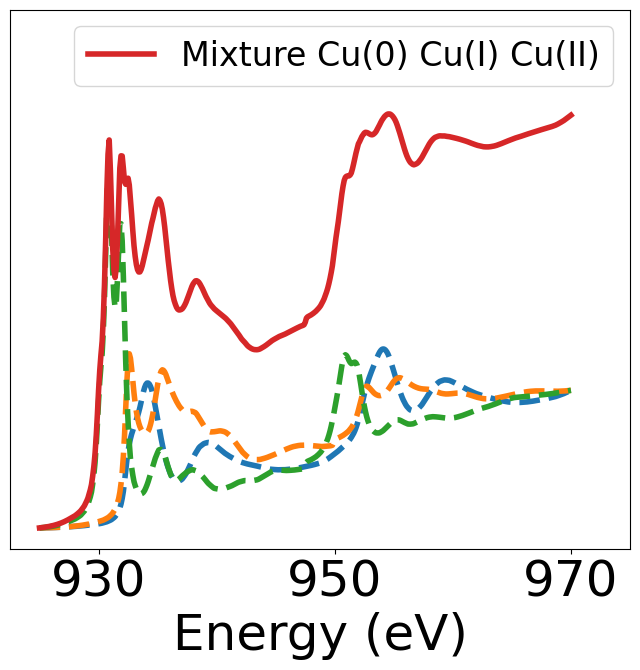

In [67]:
# visualize how integer valent spectra combine to make mixture datasets in the 3 different types of mixtures present in this 
# dataset: mixtures of Cu(0) and Cu(I), mixtures of Cu(I) and Cu(II) and mixtures of all three integer oxidation states 
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.5, 0.5, 0.0, include_title = False, savefigure = True, 
                               include_ticks = False)
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.0, 0.5, 0.5, include_title = False, savefigure = True)
test_rf_obj.visualize_mixtures('mp-12007', 'mp-8120', 'mp-1188453', 0.33, 0.33, 0.33, include_ticks = True, include_title = False,
                  savefigure = True)

<font size="6"> Validation on Experimental Samples. Figure 1 IV and Figure 3

Predicting From Cu_deconvolved_spectra\Cu Metal Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


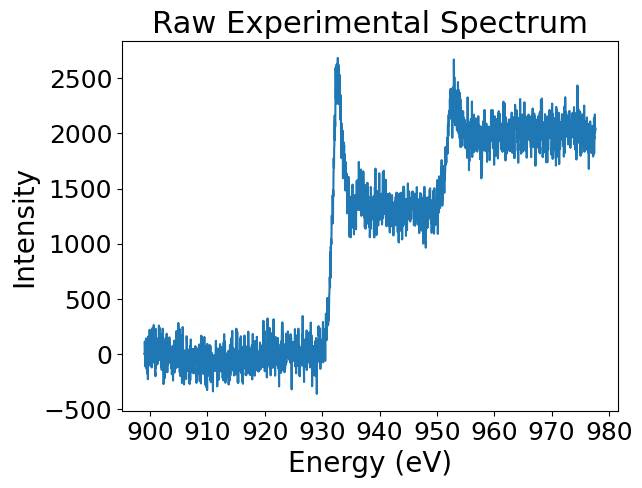

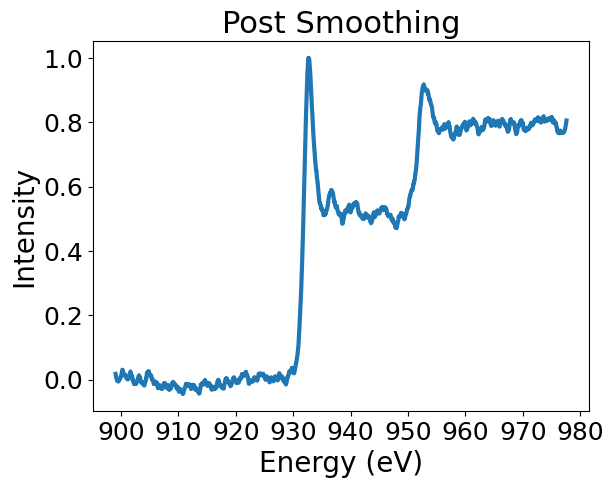

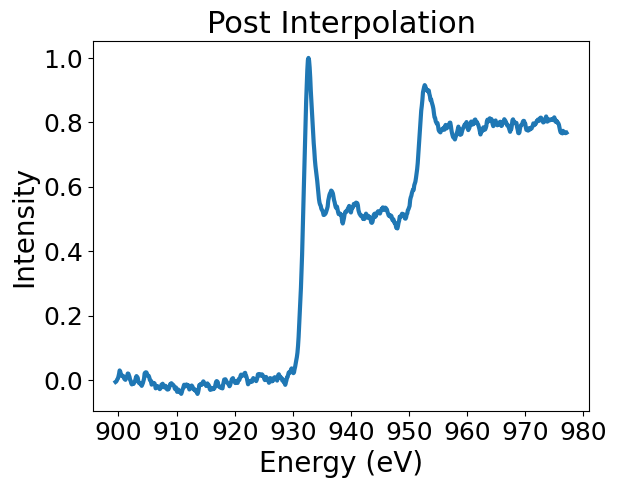

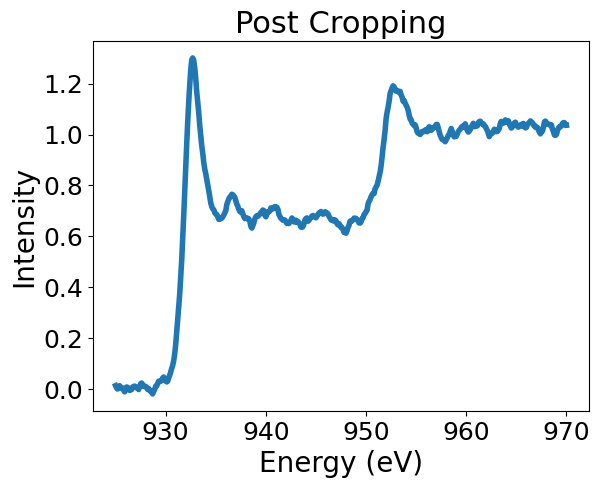

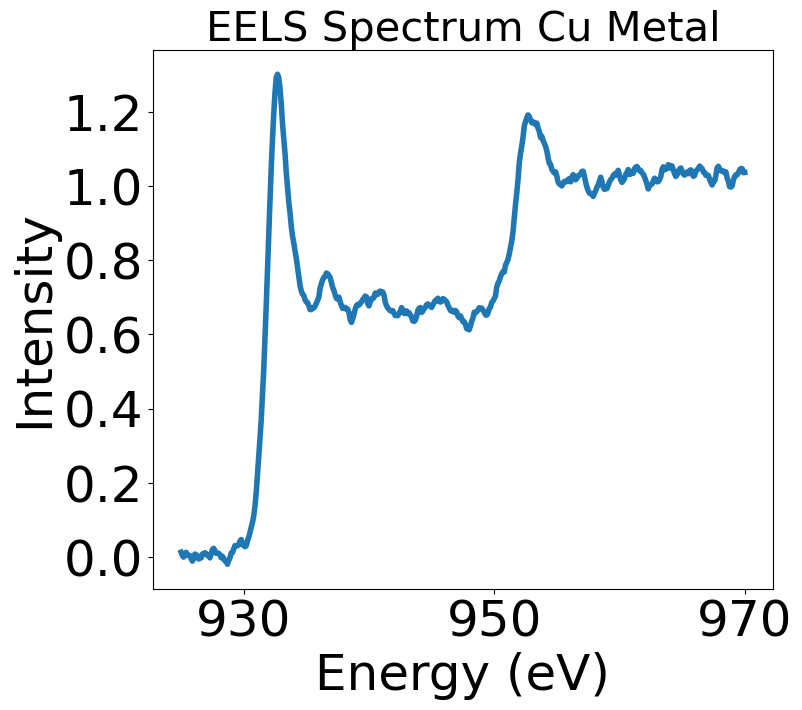

prediction = 0.31
prediction std = 0.32
 


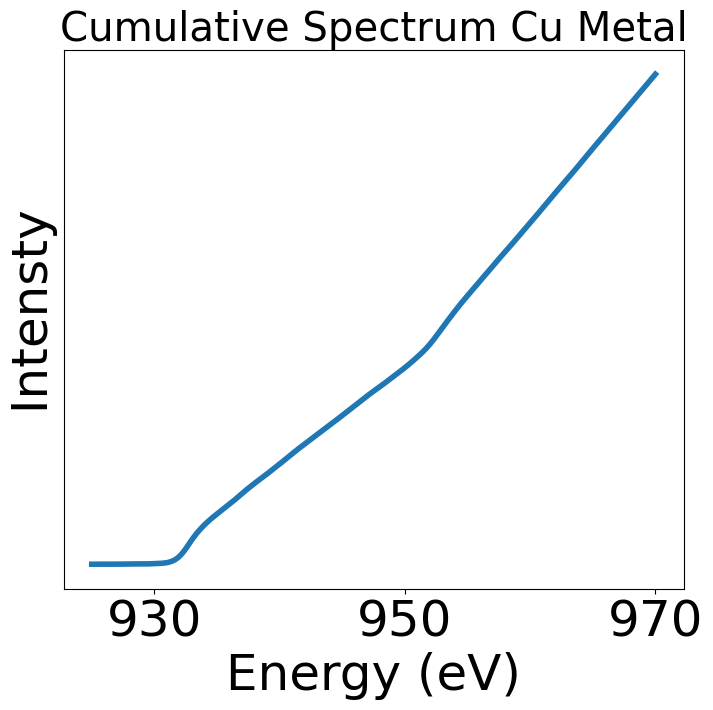

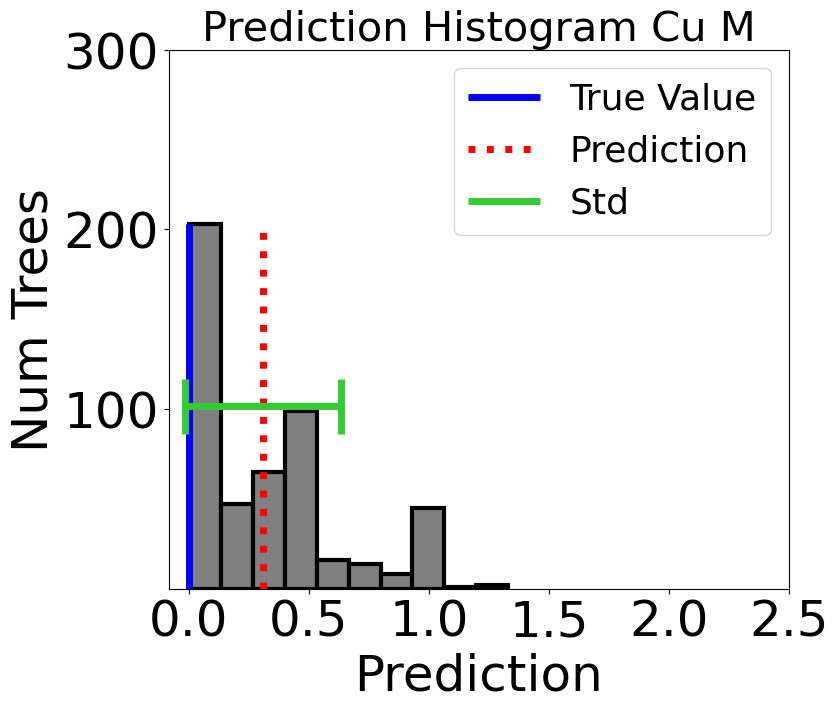

Predicting From Cu_deconvolved_spectra\Cu2O Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


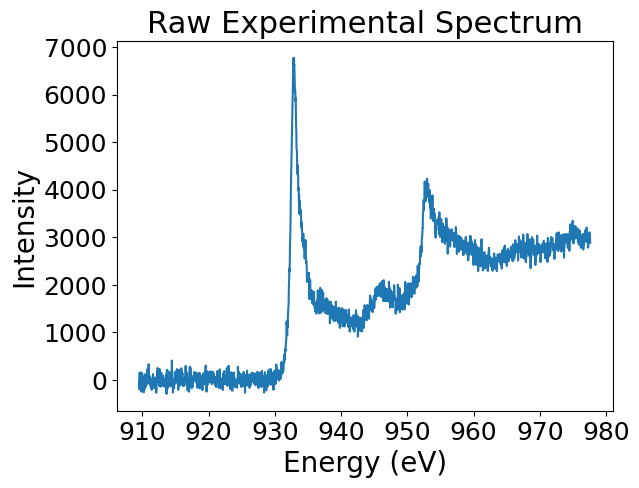

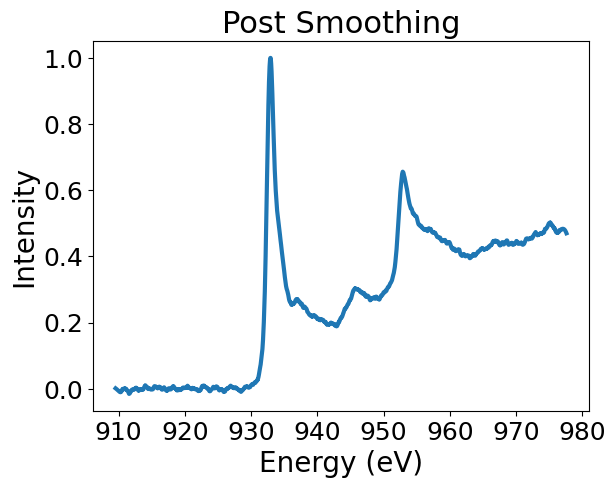

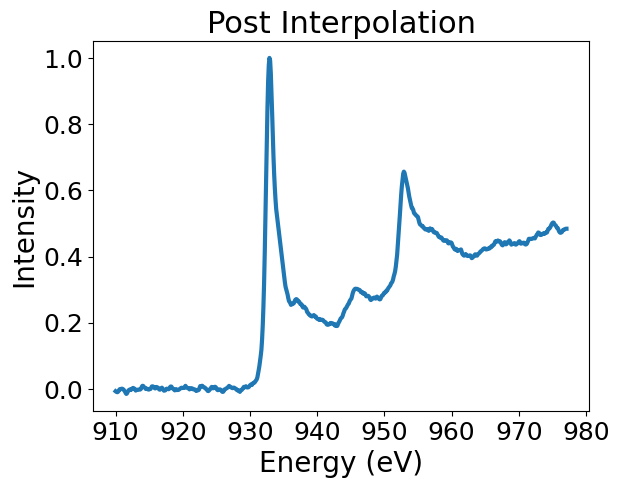

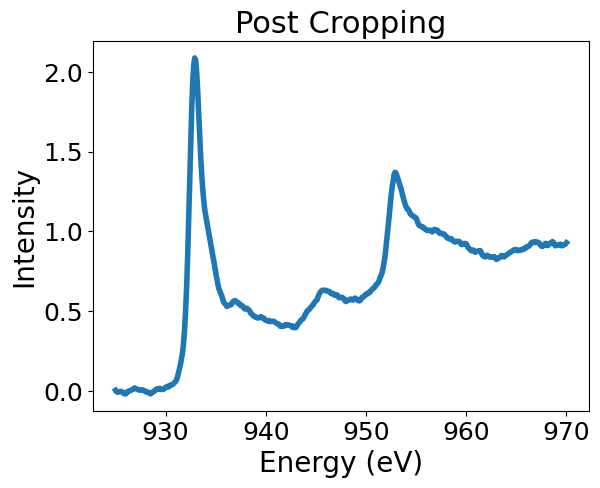

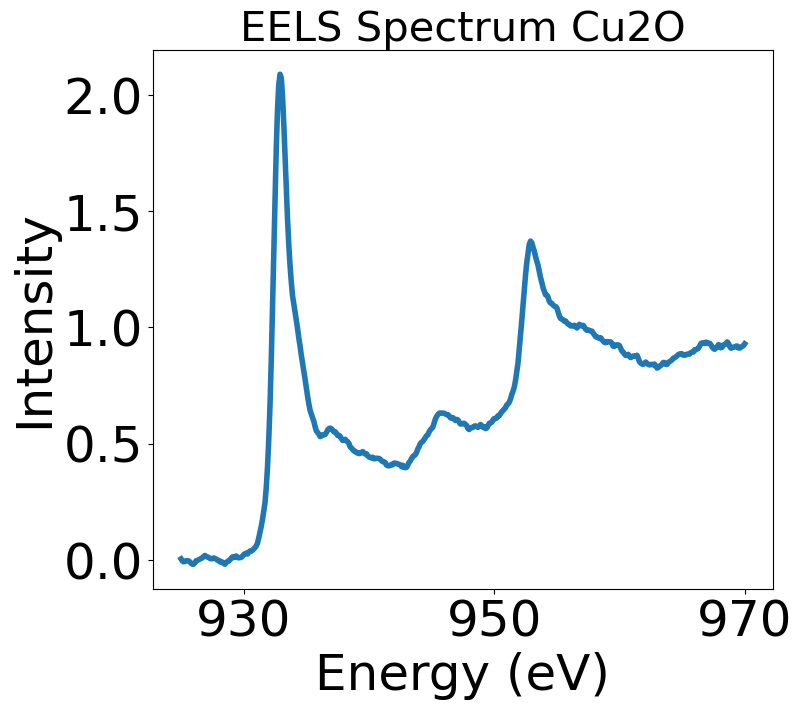

prediction = 1.08
prediction std = 0.31
 


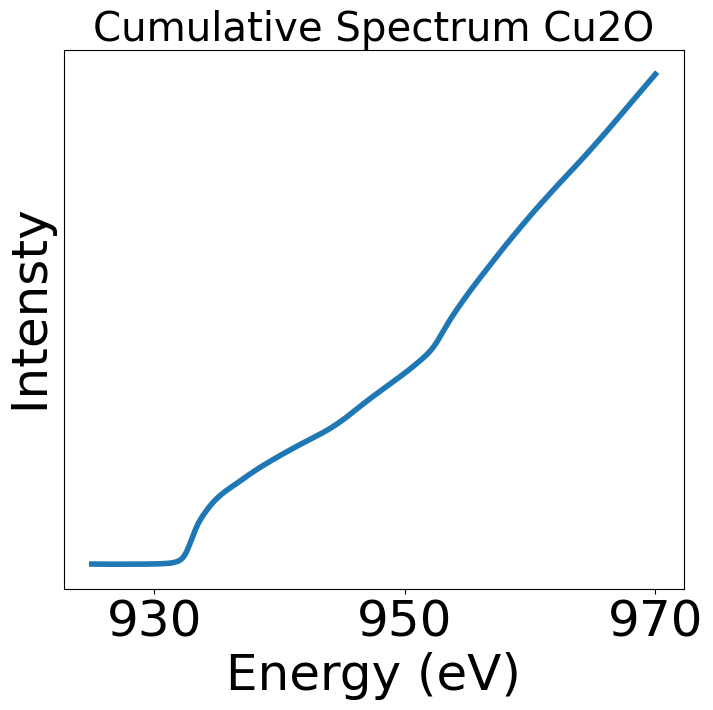

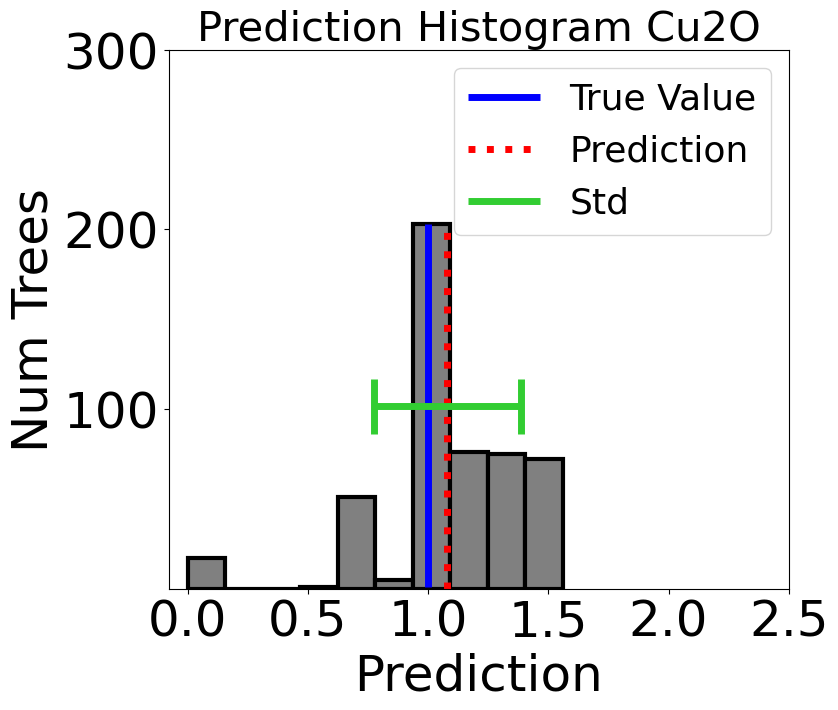

Predicting From Cu_deconvolved_spectra\CuO Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


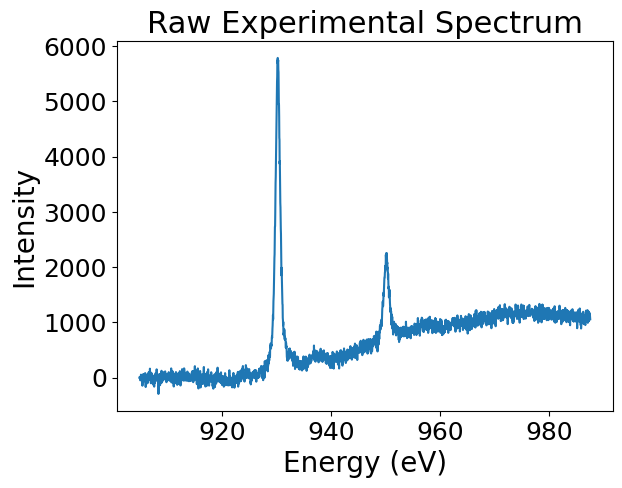

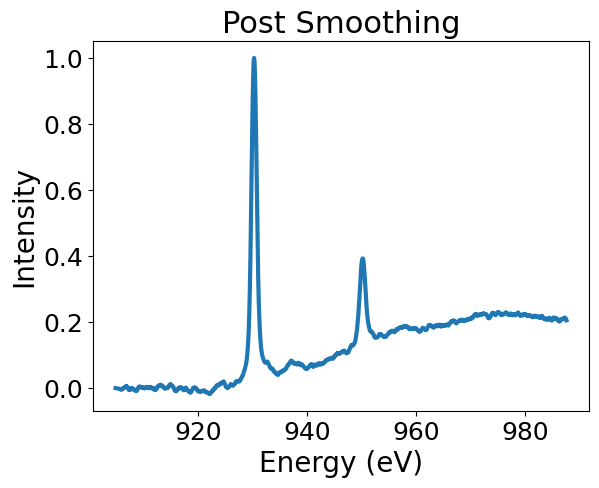

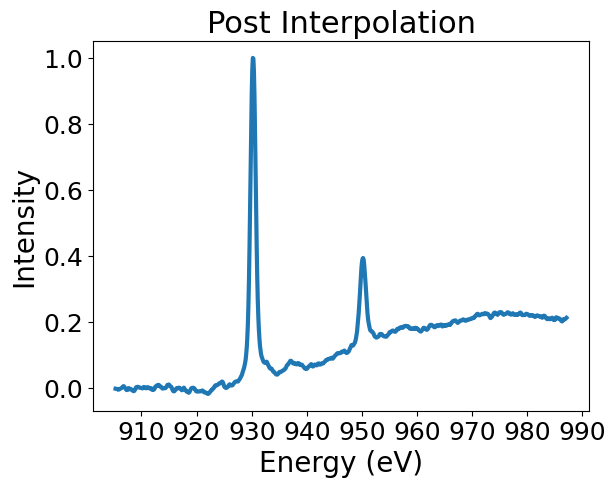

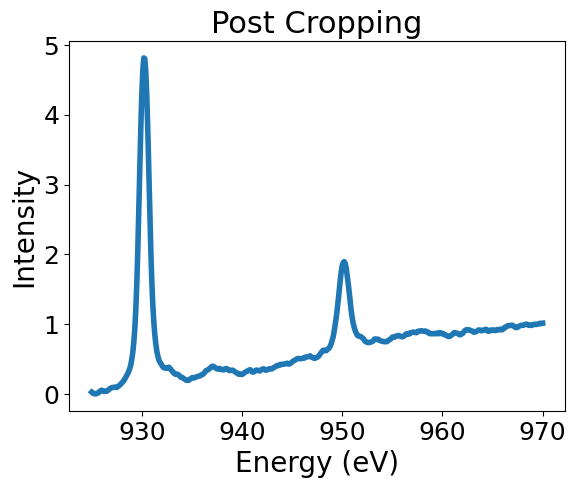

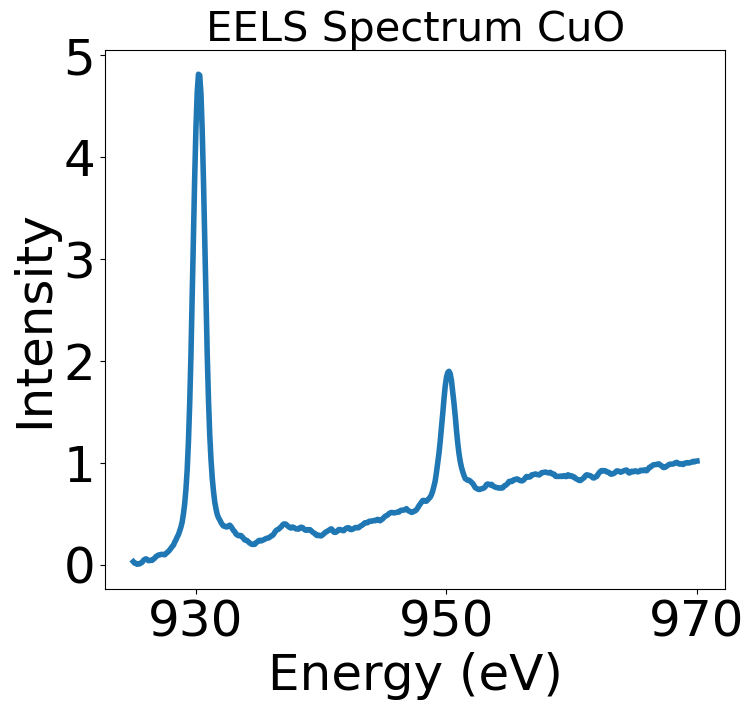

prediction = 1.99
prediction std = 0.2
 


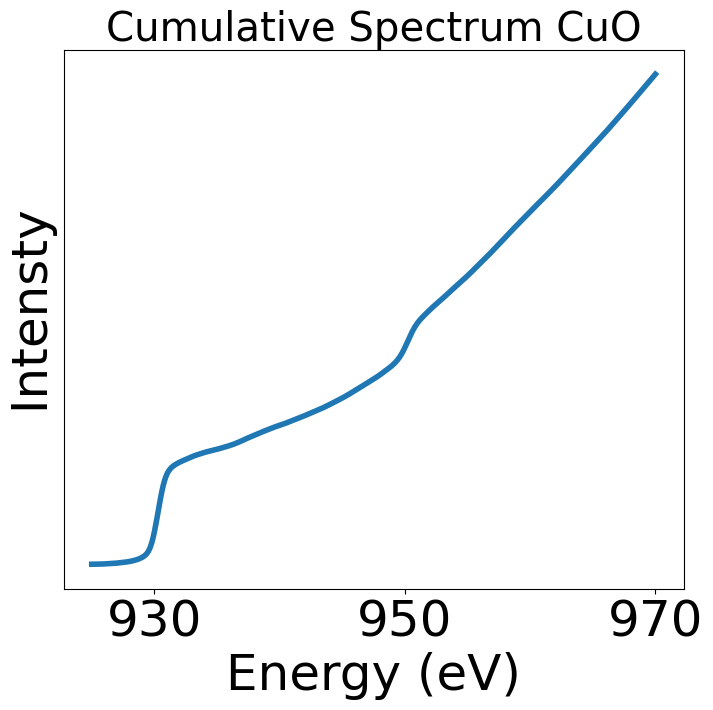

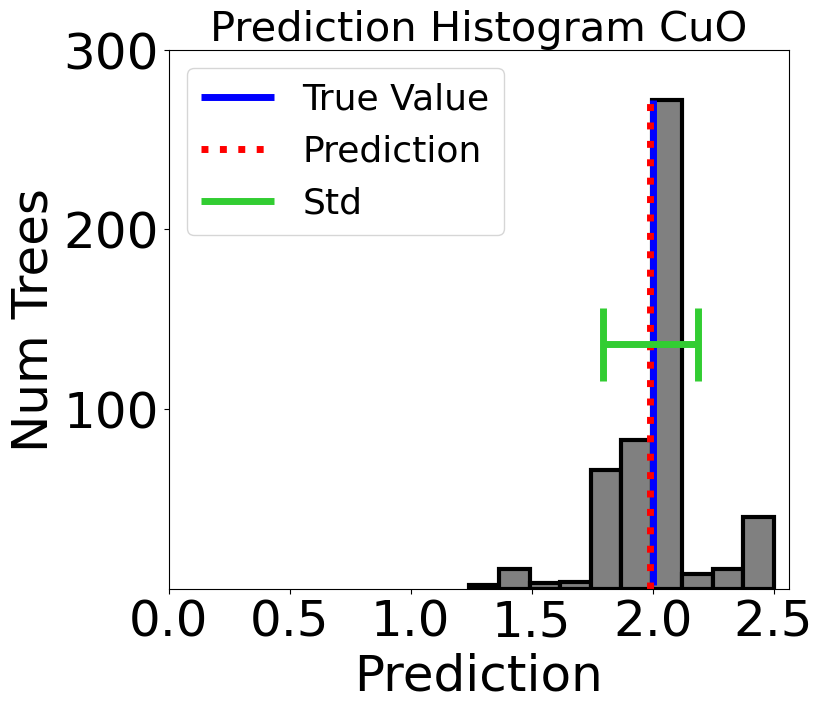

In [46]:
# predict the standards from the three experimental standards taken in this work
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = [0], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]], 
                                      show_hist=True, show_inputted_spectrum=True, print_details = True, show_plots=True,
                                     savefigure=True)

<font size="6"> Visualize Energy Axis Shift For Experimental Samples. Figure 4

In [19]:
shifts = np.linspace(-1.5,1.5,31)

In [37]:
# shift the experimental spectra energy axis and visualize how that impacts prediction 
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]],
                                     print_details = False)

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.95 │             0.38 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         1.88 │             0.51 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         1.82 │             0.52 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         1.81 │             0.47 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         1.79 │             0.49 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.98 │             0.2  │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         1.98 │             0.2  │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         1.99 │             0.19 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         1.99 │             0.19 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         1.98 │             0.19 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

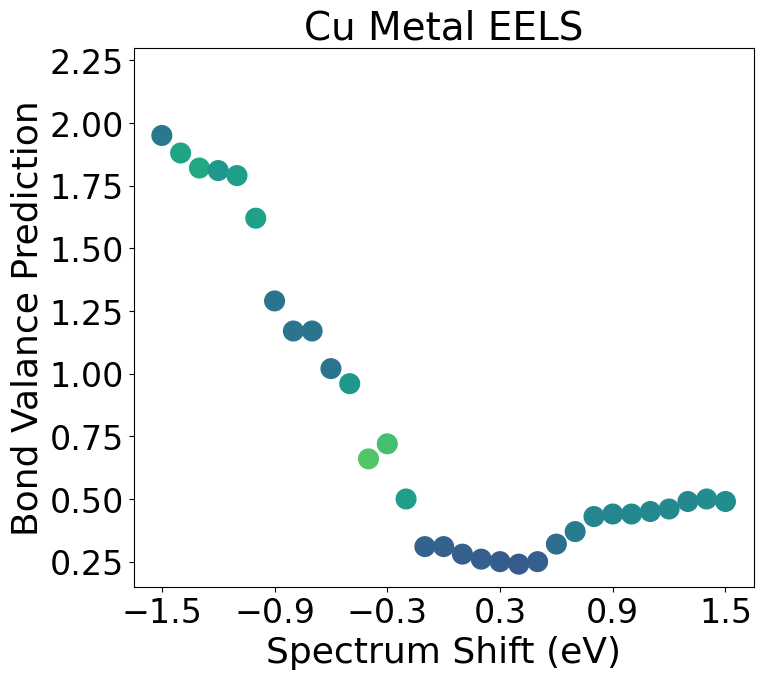

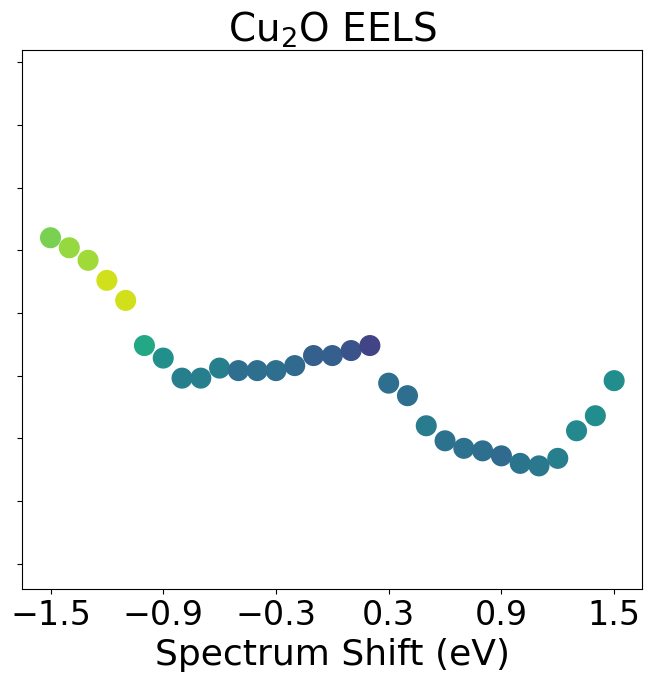

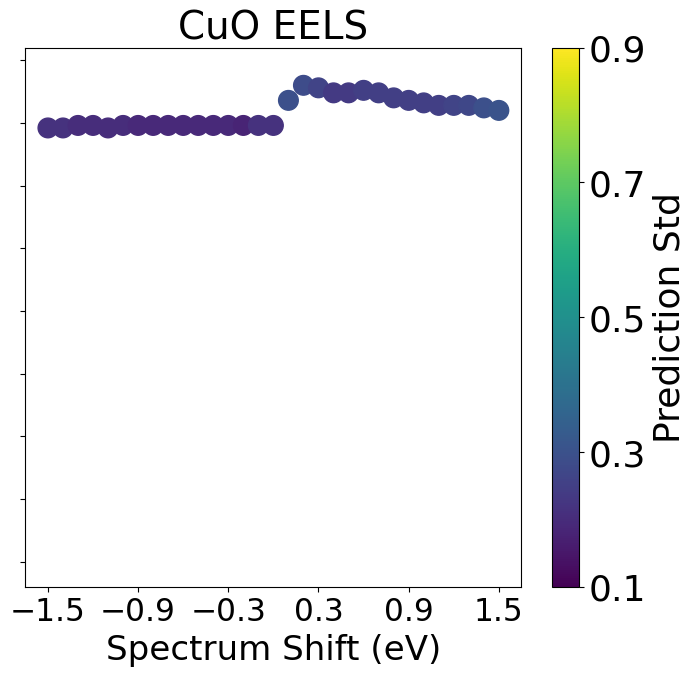

In [38]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=True, spectrum_type = 'EELS')

In [33]:
# shift the literature spectra energy axis and visualize how that impacts prediction 
# smoothing window is 15 rather than 51 because the extracted literature spectra aren't on an even spacing and need to be 
# interpolated before they can be smoothed. Therefore they are interpolated to 0.1 eV spacing first and then smoothed, 
# so the smoothing window must be correspondingly adjusted to make sure the energy window size remains at 1.5 eV 
test_rf_obj.predict_experiment_folder('xas paper/', spectra_type = 'csv', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]],
                                     print_details = False, show_hist=False, show_plots=False)


╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.12 │             0.58 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         0.89 │             0.6  │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         0.78 │             0.61 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         0.7  │             0.63 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         0.41 │             0.48 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         2.04 │             0.21 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         2.03 │             0.2  │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         2.04 │             0.21 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         2.04 │             0.22 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         2.11 │             0.26 │                      2 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

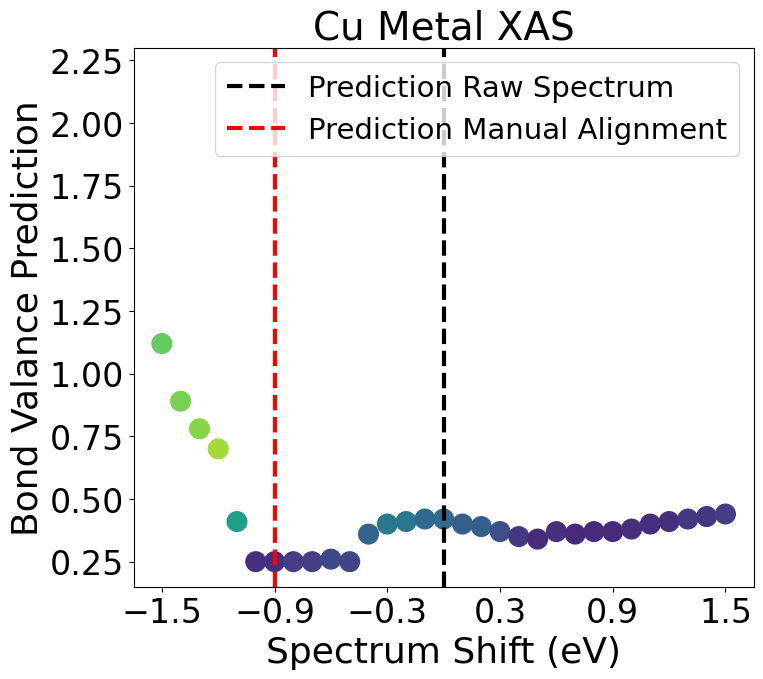

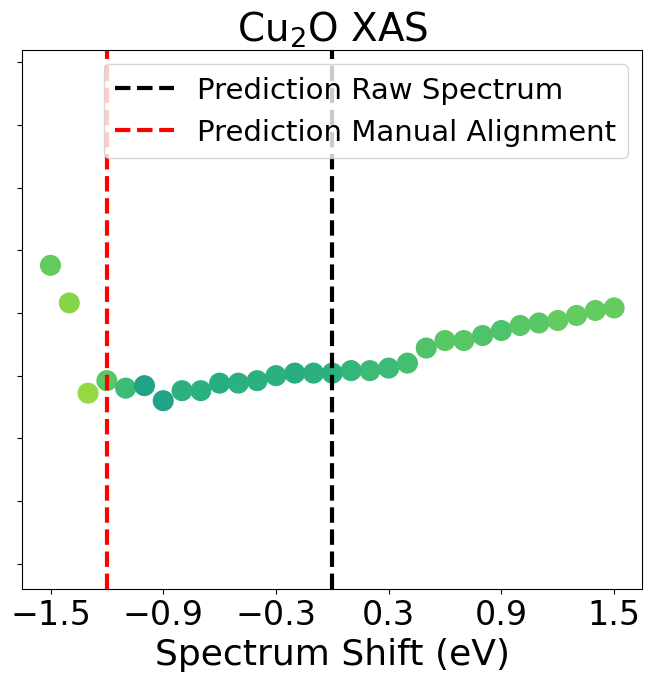

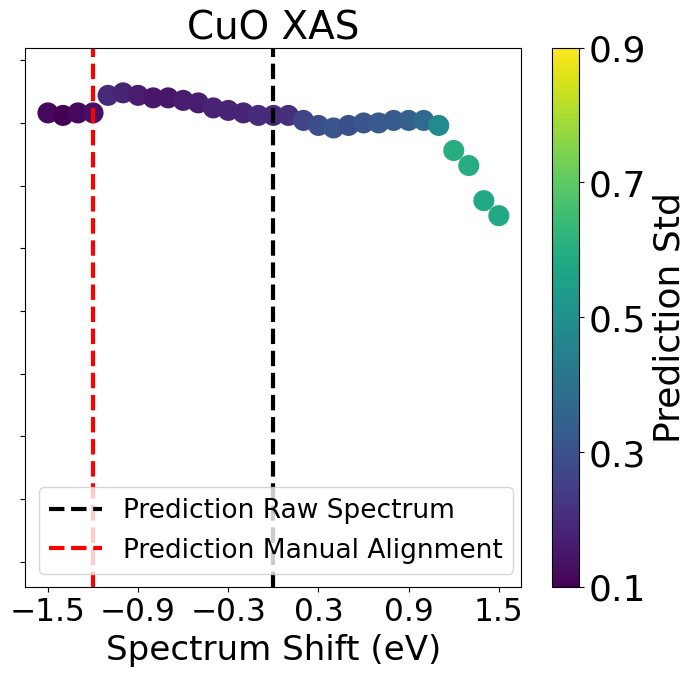

In [34]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=True, show_shift_labels = True,
                                     shift_labels = [-0.9, -1.2, -1.2], spectrum_type = 'XAS')

<font size="6"> Predict Experimental Mixtures. Figure 5

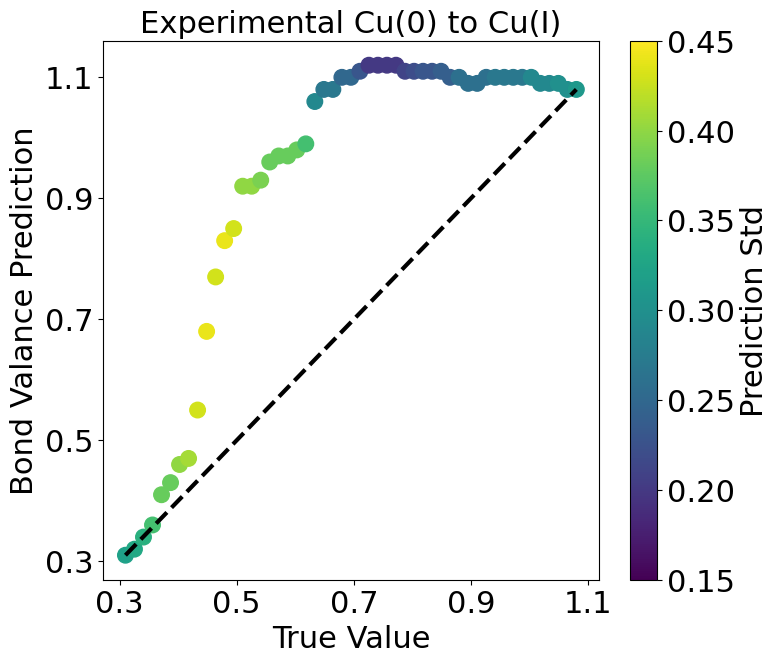

In [35]:
# predict experimental mixtures of Cu(0) and Cu(I) and Cu(I) and Cu(2)  
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = True)

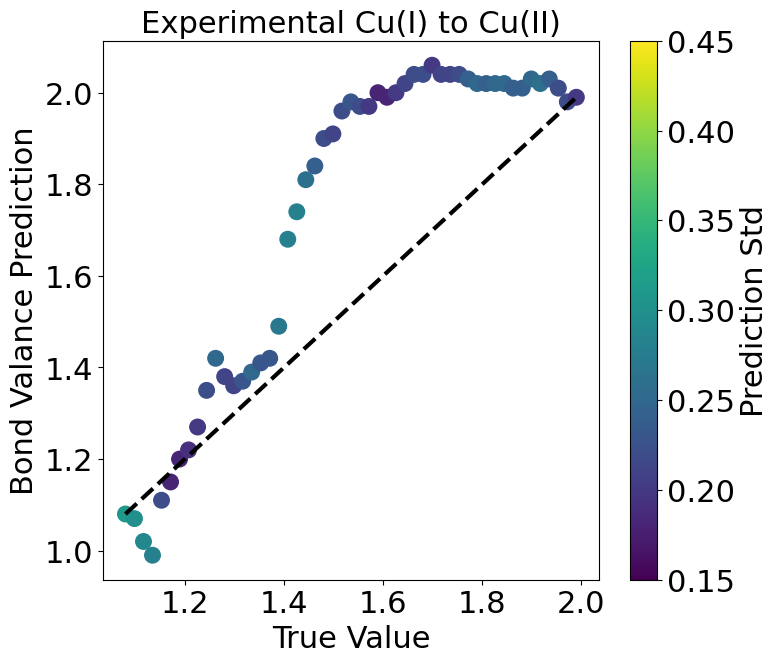

In [36]:
test_rf_obj.experimental_mixed_valent(catagory = '1-2', colorbar_range = [0.15, 0.45], savefigure = True)

<font size="6"> Augment Test Set With Noise and Predict Noisy Spectra. Figure 6

In [22]:
# interpolate test set so spectra are on a 0.03 eV spacing, the same as our experimental standards 
test_rf_obj.add_interp_spec_to_ERROR_df([0.03], False,925)

0.03


In [31]:
# generate full simulated noise analysis. This takes a very long time to run 
# test_rf_obj.full_noise_setup('Interpolated_spec_0.03', 'Interpolated_spec_energies_0.03', 0.03, 51, filename='full_noise_df_poisson_03_new.joblib')

In [51]:
# load the values generated by the cell above 
poisson_noise_df_03 = joblib.load('full_noise_df_poisson_03.joblib')

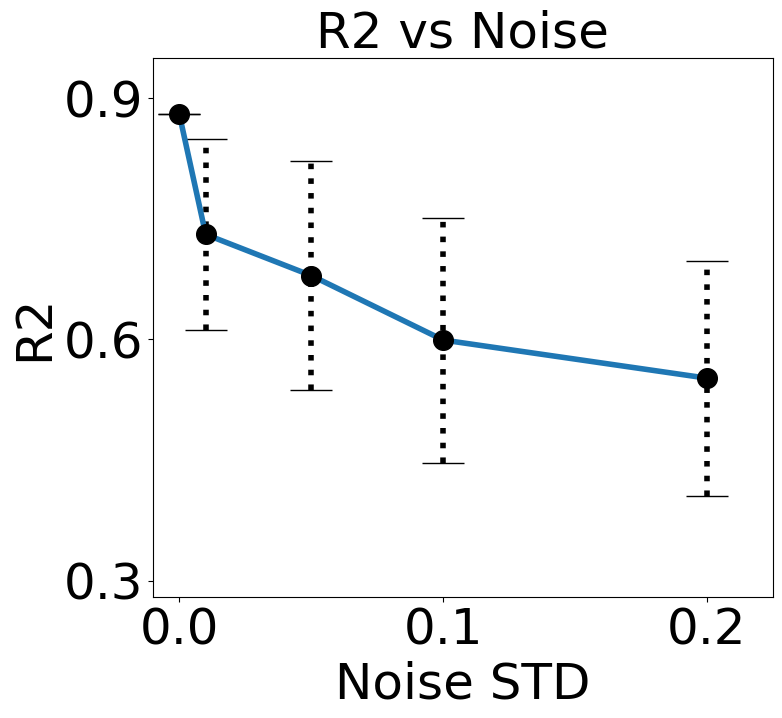

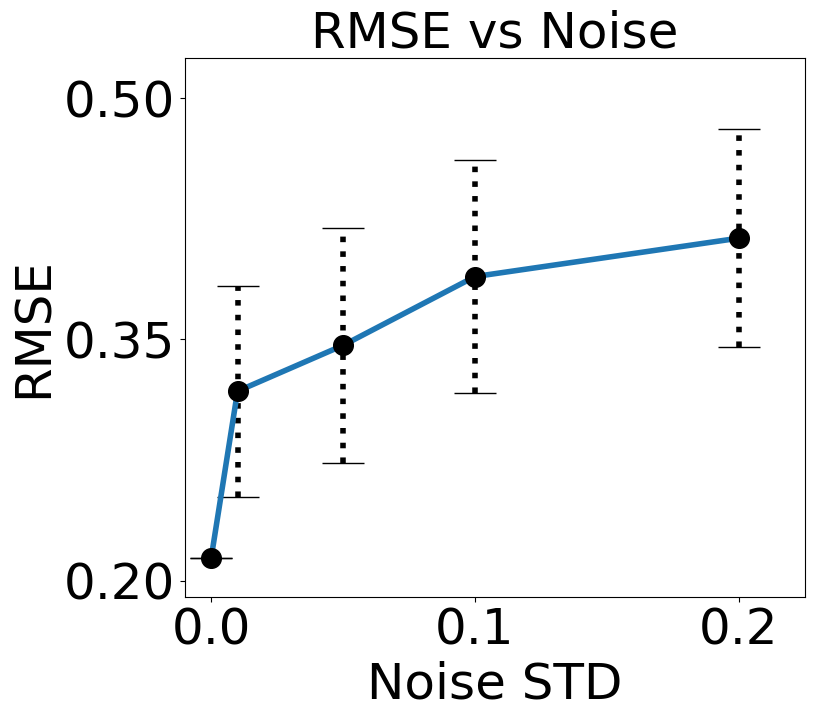

In [53]:
# plot the change in accuracy across different volumes of noise, with dotted bars showing standard deviation across 100 random 
# seeds for the noise profile generation 
visualize_full_noise_test_set([poisson_noise_df_03], [0.03], savefigure=True)

<font size="6"> Comparison between literature XAS and simulated XAS spectra for Cu metal, Cu2O and CuO. Figure S1

In [23]:
Cu_metal_path = "xas paper/Cu Metal XAS.csv"
Cu2O_path = "xas paper/Cu2O XAS.csv"
CuO_path = "xas paper/CuO XAS.csv"

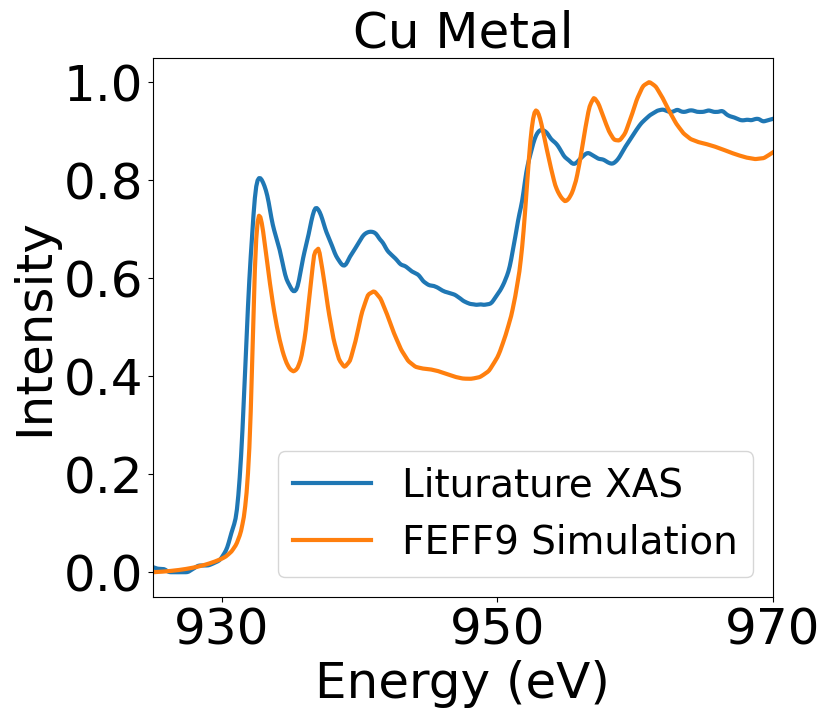

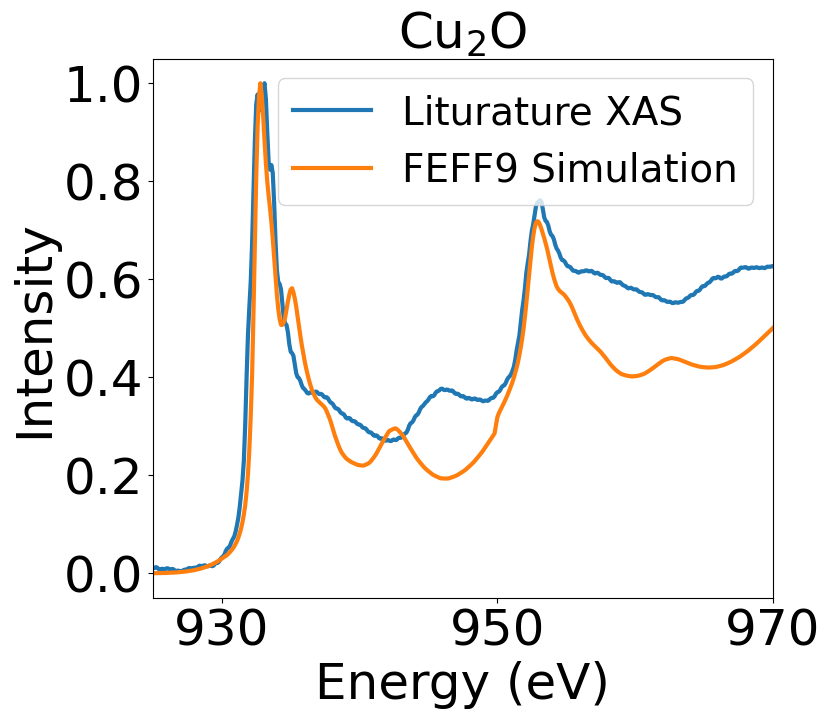

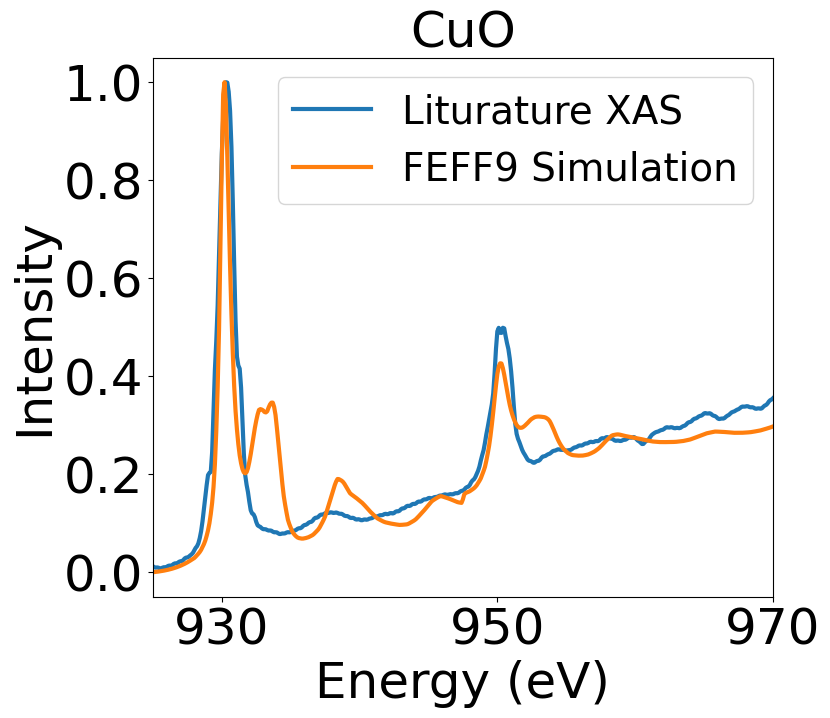

In [65]:
test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = 0.9, xlims = [925,970],
                            title = 'Cu Metal', show_experiment = False, savefigure=True)

test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = 1.2, xlims = [925,970],
                            title = 'Cu$_2$O', show_experiment = False, savefigure=True)


test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0,
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = 1.2, xlims = [925,970],
                            title = 'CuO', show_experiment = False, material = 'CuO',
                                            savefigure=True)

<font size="6"> Illustration of L2 and L3 Combination Into L2,3. Figure S2

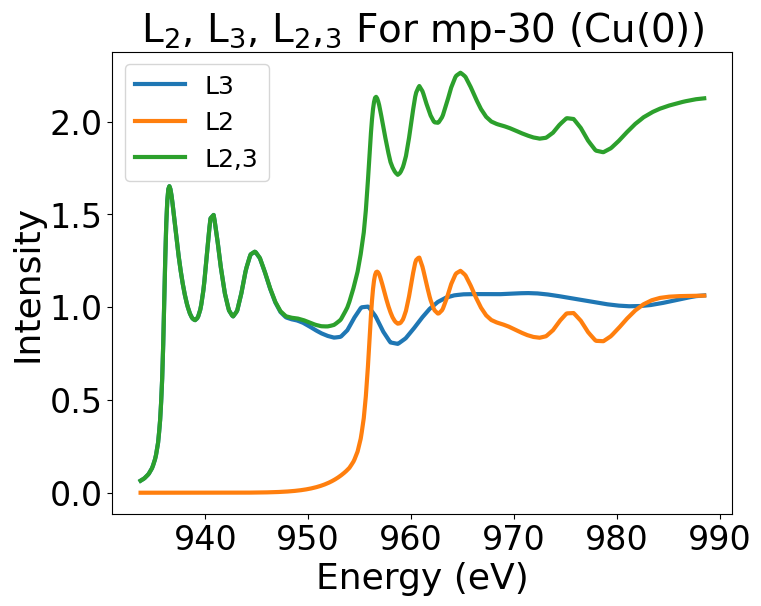

In [62]:
l2 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L2/mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])
l3 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L3//mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])

l2_3 = build_L2_3(l3, l2, savefigure=True)

<font size="6"> Illustration of The Generation of The Standardized Pre Edge Region Ensuring All Spectra Start at the same point and at Zero Intensity. Figure S3

interp min = 933.8


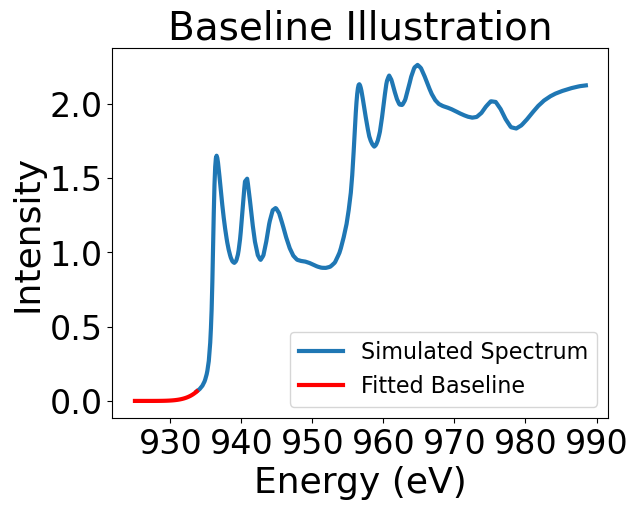

In [62]:
with open('scaled_baseline_example.pkl', 'rb') as f:
    ex_df = pickle.load(f)

ex_df = scale_spectra_flex(ex_df.loc[ex_df.mp_id == 'mp-30'], zero_energy = 925, show_plot=True, savefigure=True)

<font size="6"> R2 Plot of integer valence spectra used to build the mixture dataset. Figure S5

Accuracy = 0.9751936864449045
RMSE = 0.1284148037774664
num spectra = 541
model accuracy (R^2) on simulated test data 0.8889127604122083
RMSE 0.1284148037774664


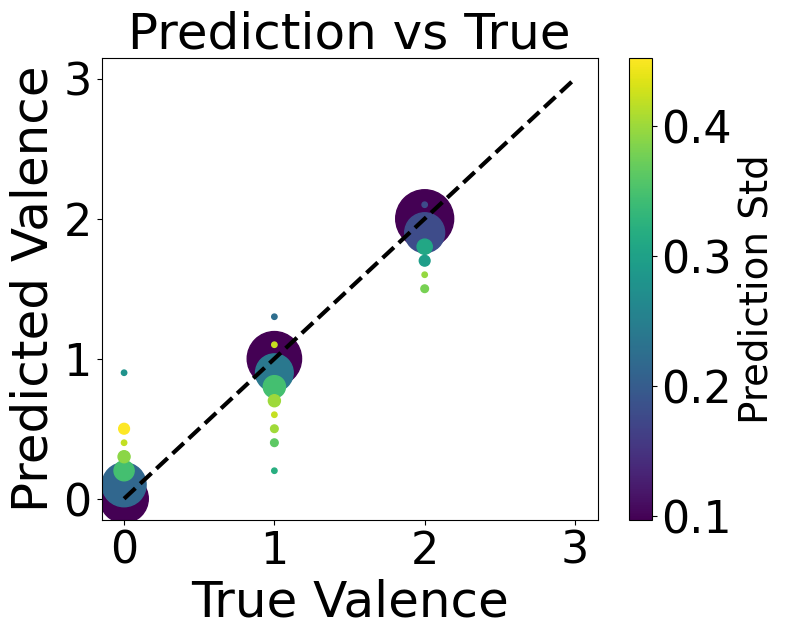

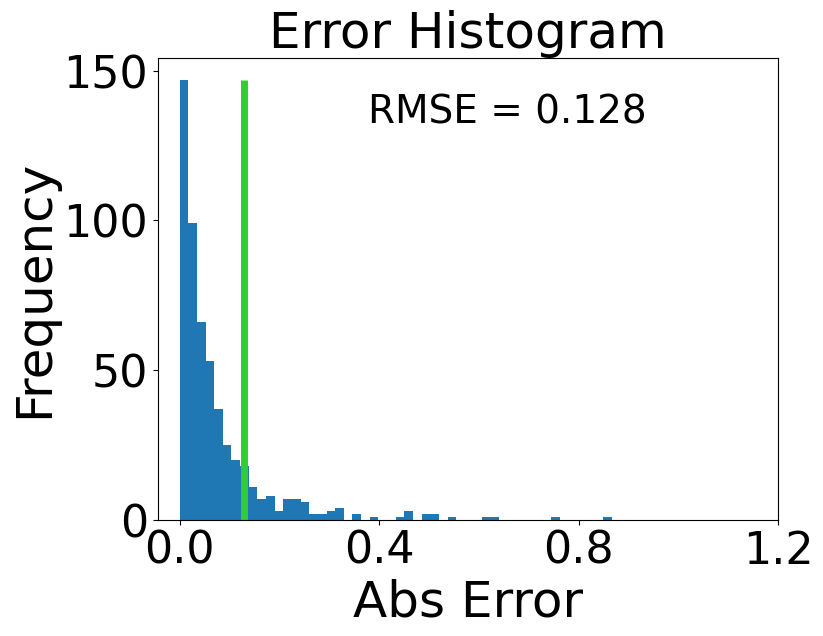

In [17]:
test_rf_obj.show_mixture_samples_accuracy(savefigure=True)

<font size="6"> Standard Deviation Thresholds. Figure S6

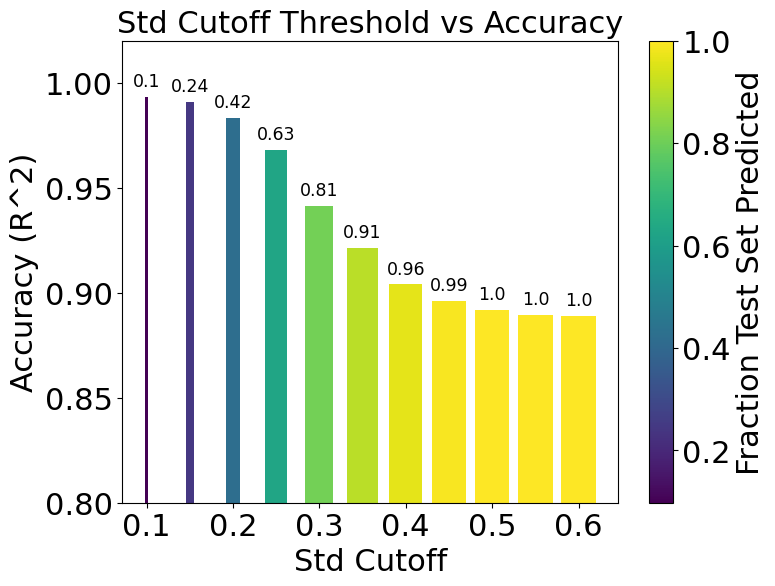

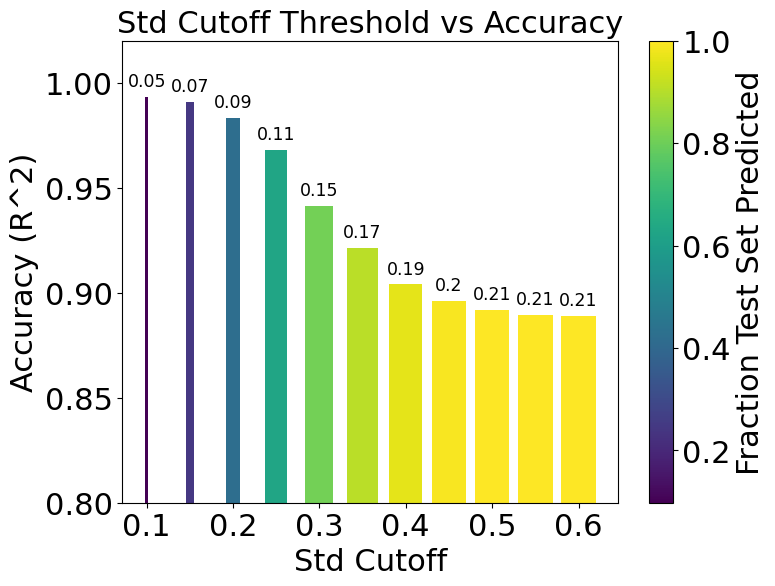

In [19]:
thresholds = np.arange(0.1, 0.65, 0.05)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.8, 1.02], text_fontsize = 12.5, show_type = 'percentage_predicted', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=True)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.8, 1.02], text_fontsize = 12.5, show_type = 'RMSE', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=True)

<font size="6"> Full Experimental Workflow. Figure S7

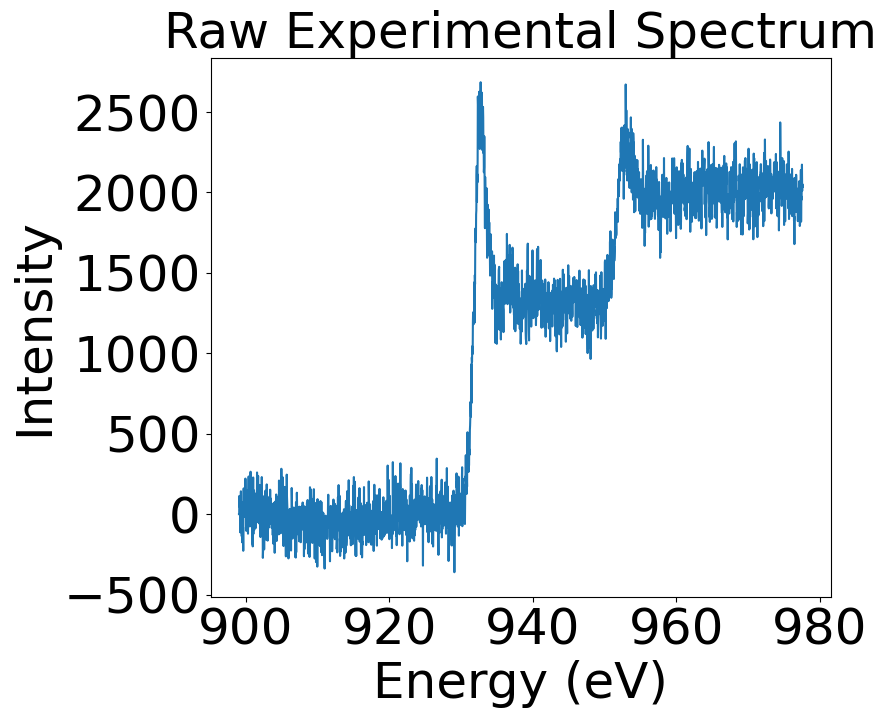

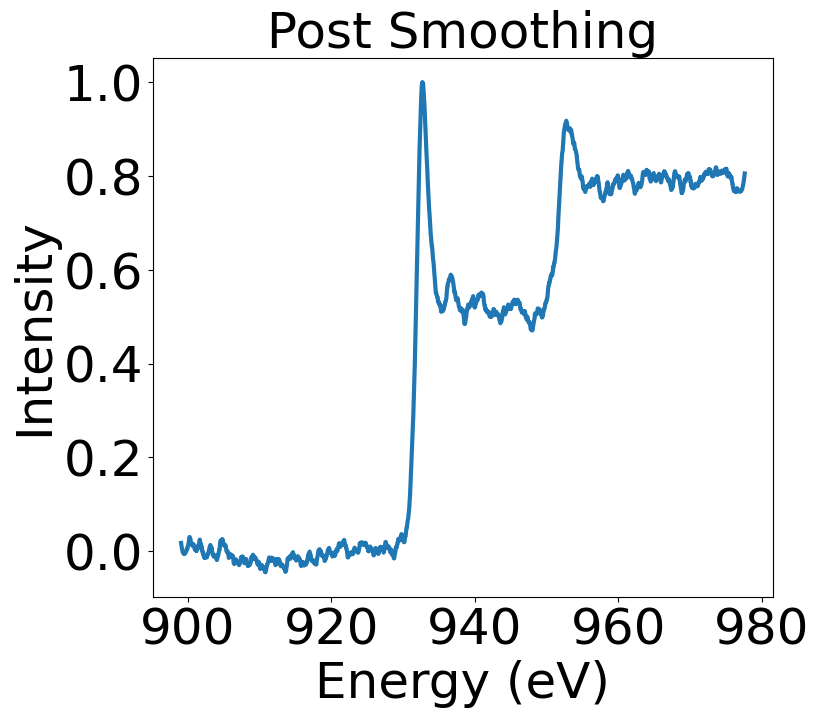

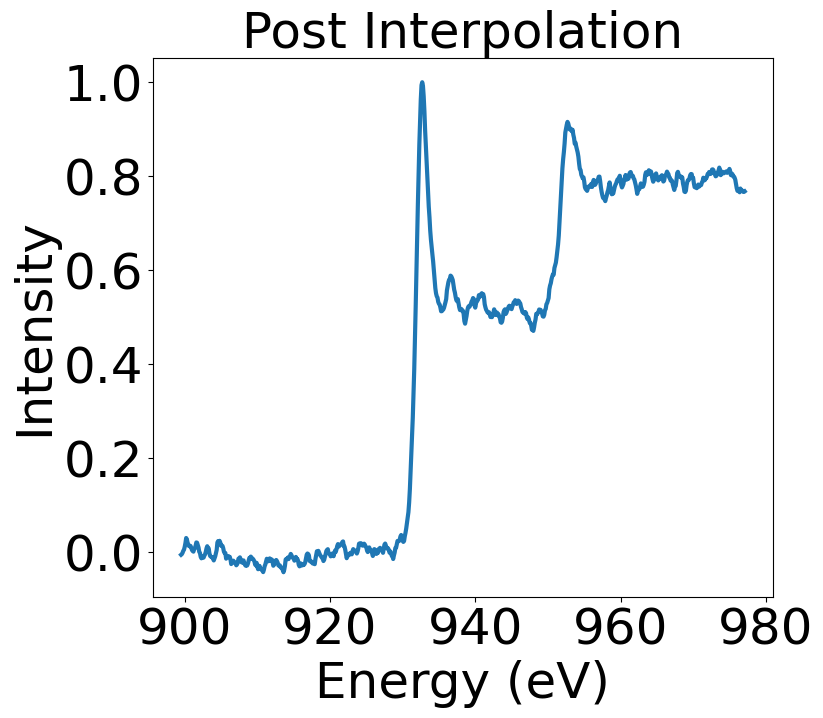

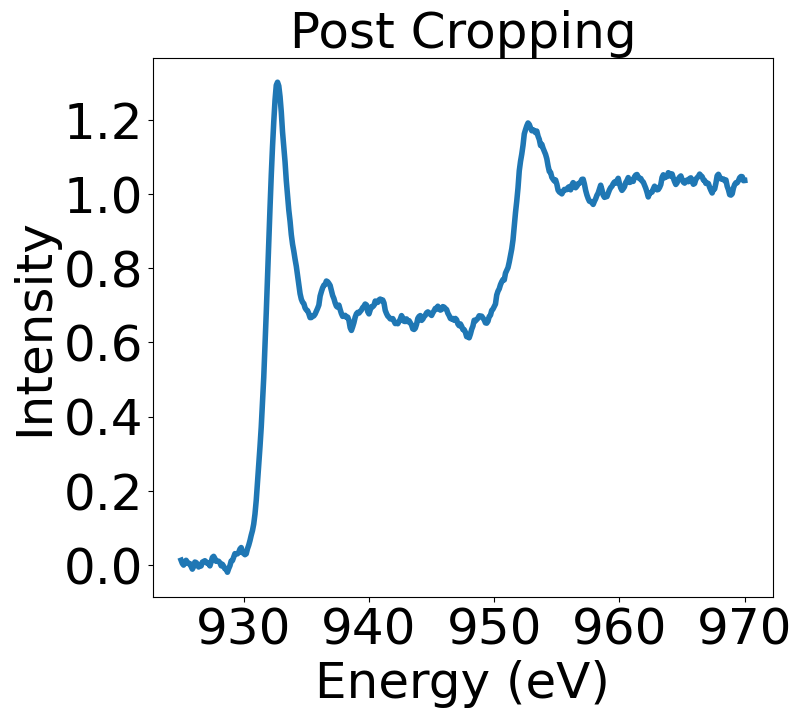

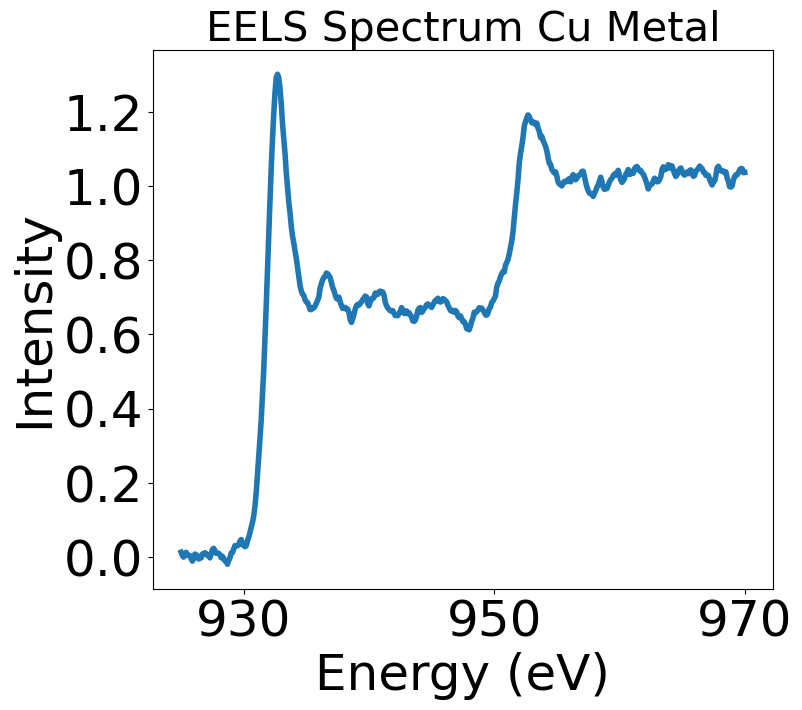

prediction = 0.31
prediction std = 0.32
 


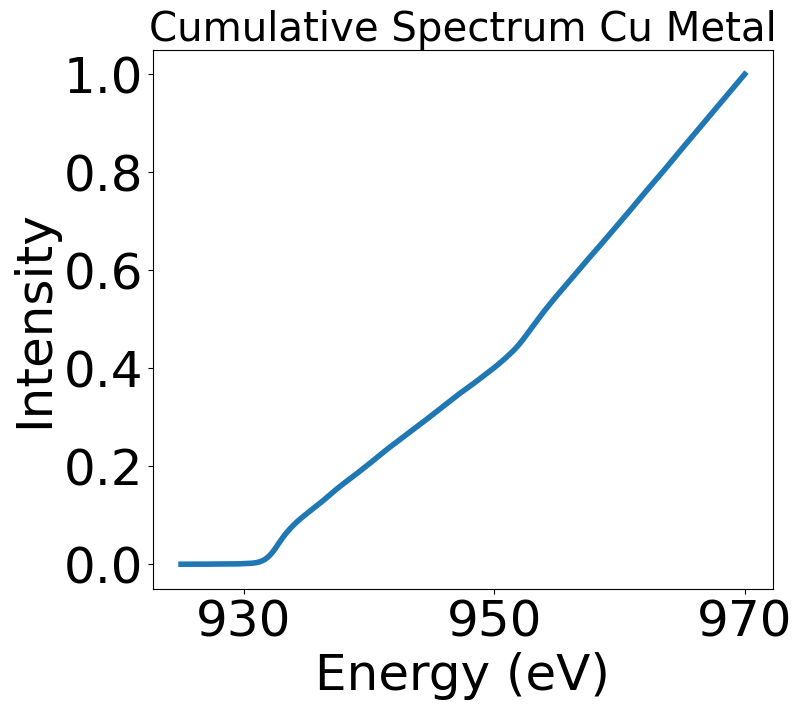

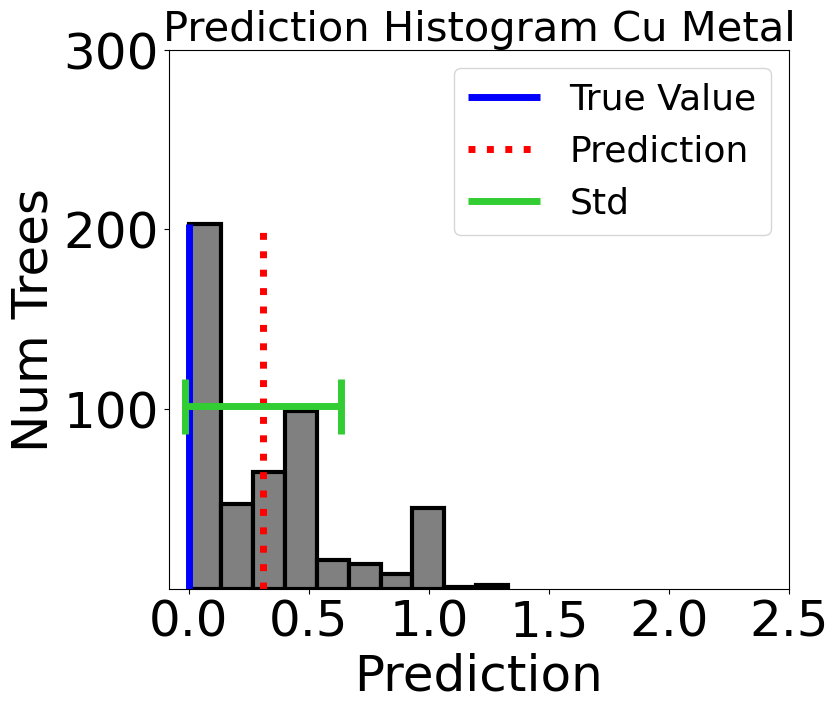

In [48]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4',
                                             1640, 'Cu Metal', exp_spectrum_type='TEAM I',
                                            smoothing_parms=[51,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=0.0, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=True, show_inputted_spectrum = True,
                                            savefigure=True)

<font size="6"> Experimental EELS vs Literature XAS Cu Metal and Cu2O. Figure S8

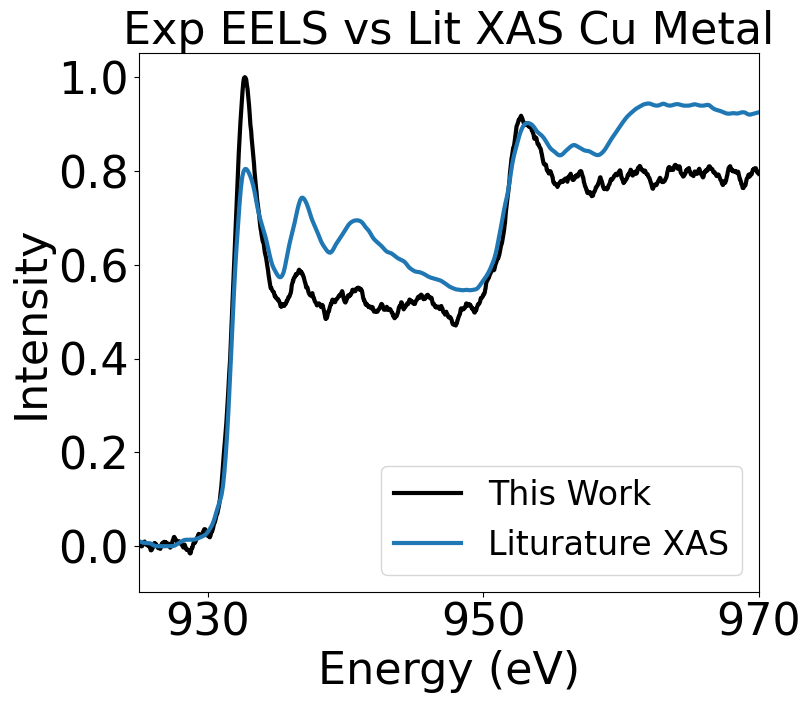

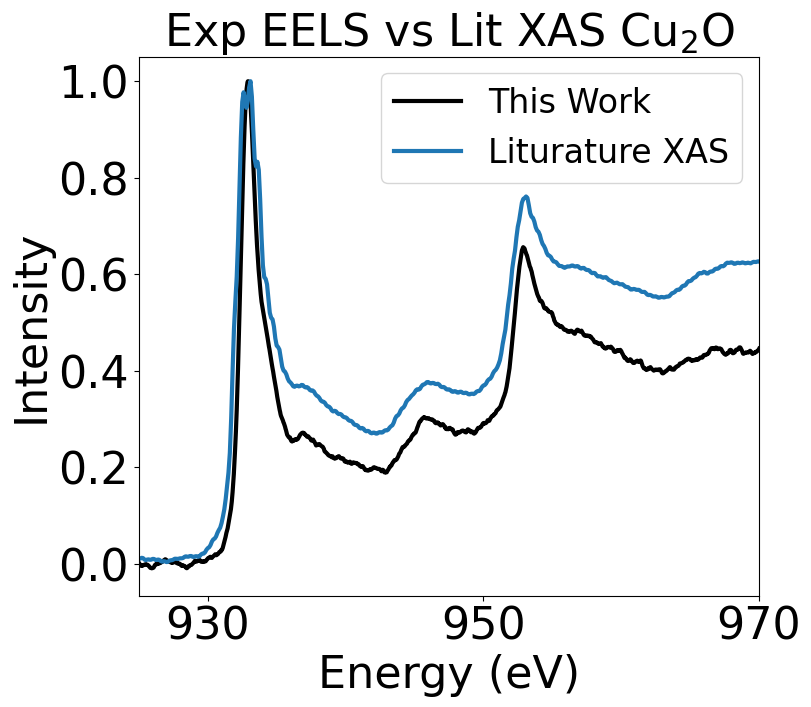

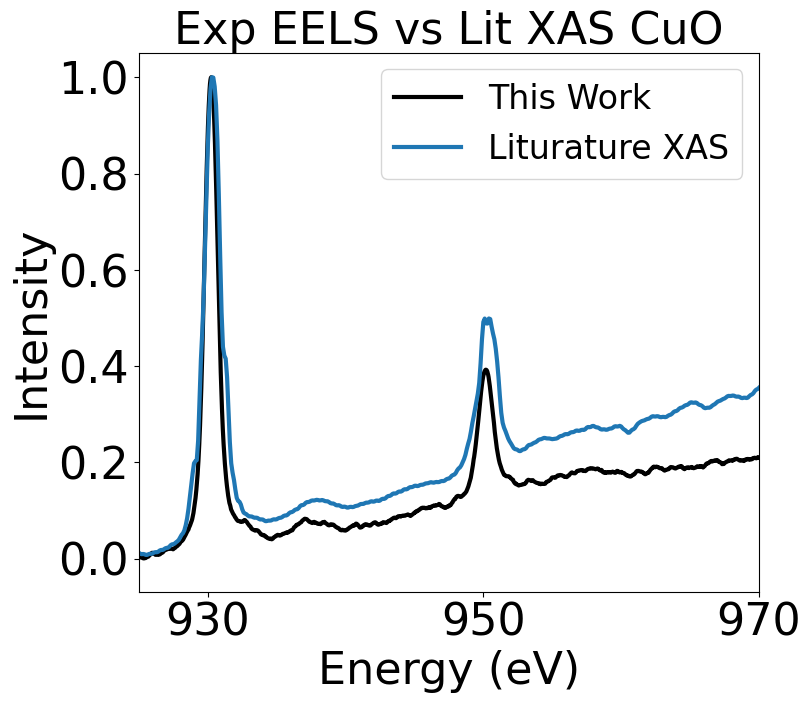

In [51]:
test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = 0.9, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu Metal', show_experiment = True, savefigure=True)


test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = 1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu$_2$O', show_experiment = True, savefigure=True)

test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'CuO',
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = 1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS CuO', show_experiment = True, savefigure=True)

<font size="6"> Simulated Mixture Spectra, Mixtures of Cu metal, Cu2O and CuO. Figure S9

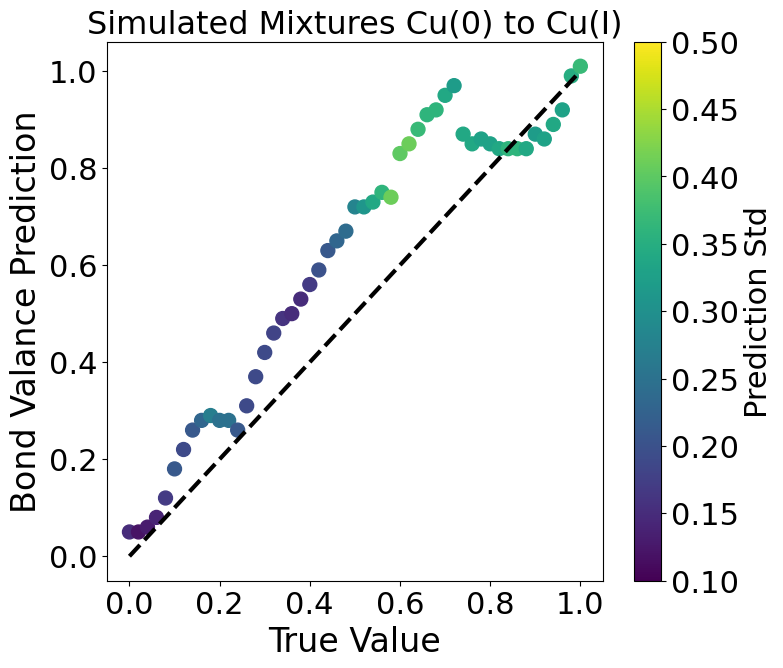

In [28]:
test_rf_obj.simulated_mixed_valent(catagory = '0-1', savefigure=True)

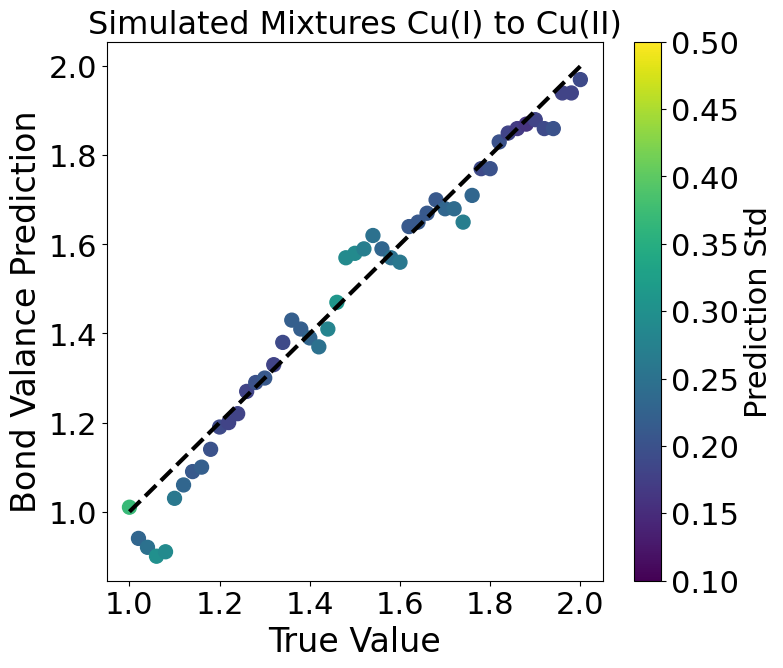

In [29]:
test_rf_obj.simulated_mixed_valent(catagory = '1-2', savefigure=True)

<font size="6"> Impact of Smoothing on Experimental EELS Spectra Predictions. Figure S10

In [33]:
smoothings = [[5,3], [21,3], [35,3], [51,3], [75,3], [101,3], [125,3], [151,3]]

In [52]:
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', show_plots=False,
                                      shifts = [0.0], theory_column = 'TEAM_1_aligned_925_970', smoothings = smoothings, 
                                      show_hist=False, show_inputted_spectrum=False, savefigure=False, print_details=False)

╒═════════════════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Smoothing Window (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞═════════════════════════╪══════════════╪══════════════════╪════════════════════════╡
│                    0.15 │         0.64 │             0.49 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    0.63 │         0.36 │             0.39 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.05 │         0.31 │             0.33 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.53 │         0.31 │             0.32 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    2.25 │         0.31 │ 

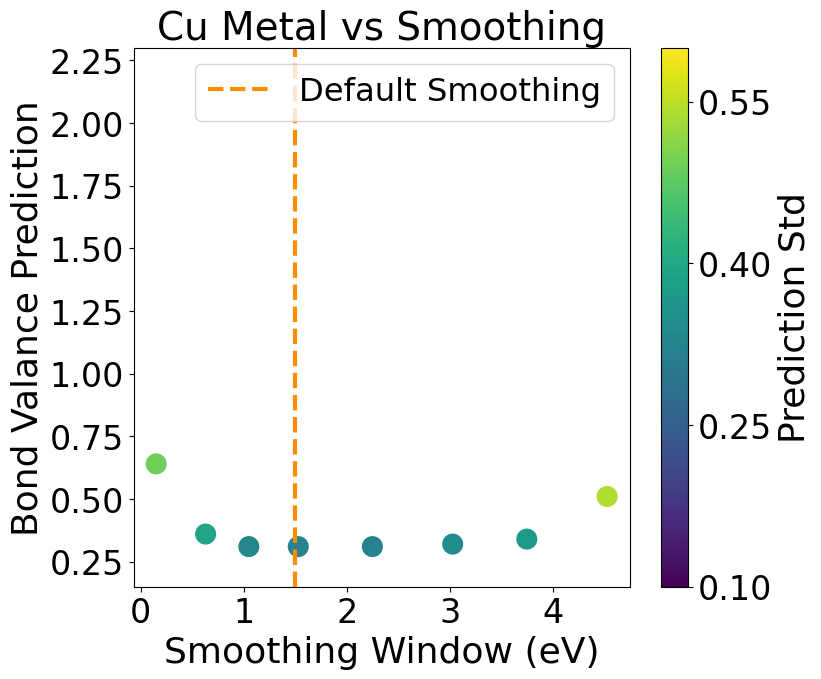

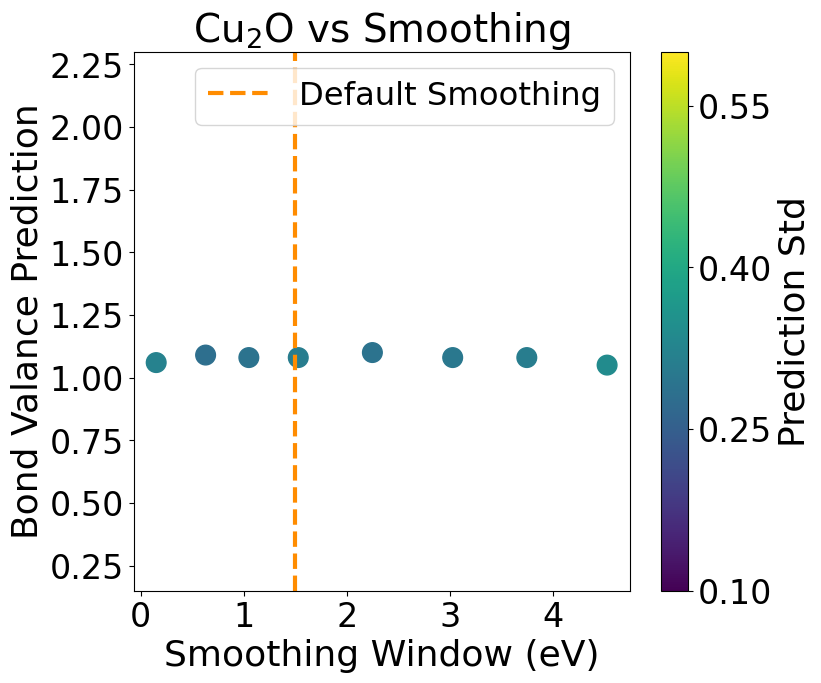

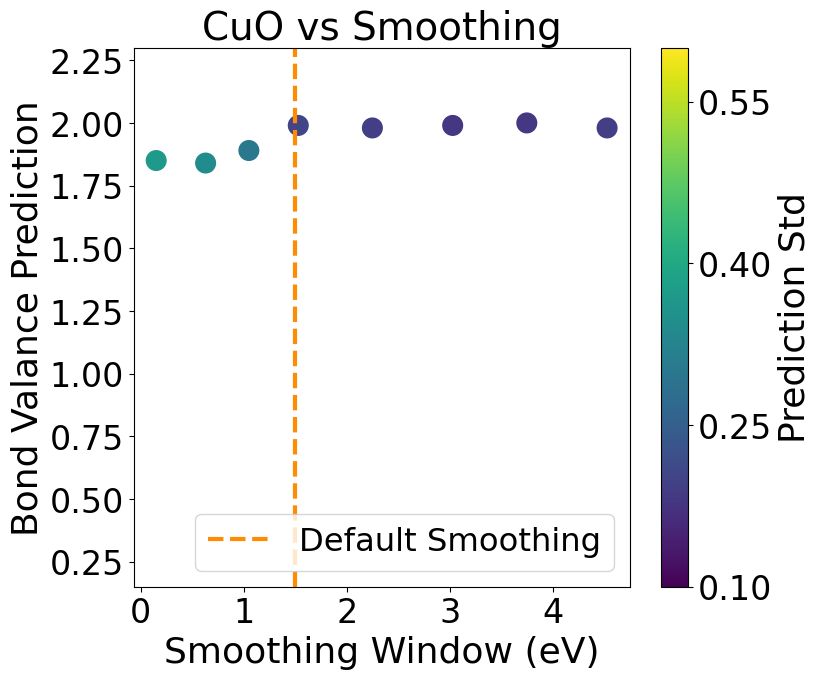

In [61]:
test_rf_obj.visualize_smoothings(show_table=True, savefigure=True)